In [1]:
%matplotlib inline
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchgp.symbolic import *
from torchgp.transforms import *
from torchgp.reparameterization import *
from torchgp.test_tools import *
from torchgp.kernels import *
from torchgp.parameterizations.titsias import *
from torchgp.parameterizations.structured import Symmetric2DVector
from torchgp.structure import rkr_mv
import math
import networkx as nx
from matplotlib.pyplot import *

## Example 1

1. Sum of two linear GPMM signals from two independent SASE sources
2. Gaussian likelihood
3. MC for evaluation of variational expectation
4. Both signals share the same f axis


In [2]:
class TwoSASE1DSignals(torch.nn.Module):
    def __init__(self, UA, UB, F):
        """
        This is a fake data generator for chain GP problem. It's not a physical signal, just one
        where the signal has known hyper parameters. Useful for checking proper convergence of the
        optimization problem.
        """

        super().__init__()
        self.UA = UA
        self.UB = UB
        self.F = F
        m1 = Vector('m1')
        m2 = Vector('m2')
        KA = Kernel('KA')
        KB = Kernel('KB')
        ua = Vector('ua')
        ub = Vector('ub')
        f = Vector('f')
        mf_A = mean_1D(KA, ua, f, m1)
        mf_B = mean_1D(KB, ub, f, m2)
        graph = expr2graph(Label(String("mf_B"), mf_B))
        self._mf_B = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("mf_A"), mf_A))
        self._mf_A = graph2ast(graph, compiled=True, debug=False)
        self._makepos = SoftplusTransform()
        self.stored_kernels = torch.nn.ModuleDict({
            'KA': ARDRBFKernel(lengthscale=torch.tensor([[0.05]]),
                                  transforms=[self._makepos, self._makepos]),
            'KB': ARDRBFKernel(lengthscale=torch.tensor([[0.05]]),
                                  transforms=[self._makepos, self._makepos])
        })
        with torch.no_grad():
            m1 = torch.empty(UA, 1).normal_() * torch.linspace(-1, 1, UA).div(0.8).pow(2).neg().exp().reshape(-1, 1)
            m2 = torch.empty(UB, 1).normal_() * torch.linspace(-1, 1, UB).div(0.8).pow(2).neg().exp().reshape(-1, 1)
            self.params = torch.nn.ParameterDict({
                'm1': torch.nn.Parameter(m1.pow(2)),
                'm2': torch.nn.Parameter(m2.pow(2)),
                'f': torch.nn.Parameter(torch.linspace(-1, 1, F).unsqueeze(1)),
                'ua': torch.nn.Parameter(torch.linspace(-1, 1, UA).unsqueeze(1)),
                'ub': torch.nn.Parameter(torch.linspace(-1, 1, UB).unsqueeze(1)),
            })

    def mean_B(self):
        leaves = {
            **self.params,
            **self.stored_kernels,
        }
        r = self._mf_B(**leaves)
        return r.mf_B.detach()

    def mean_A(self):
        leaves = {
            **self.params,
            **self.stored_kernels,
        }
        r = self._mf_A(**leaves)
        return r.mf_A.detach()

    def make_fake_data(self, Nshots):
        S_A = self.mean_A()
        X = torch.from_numpy(make_sase(self.F, Nshots).astype('float32'))
        X = X / X.max()
        #         c0_A = X.sum(dim=1).mean()
        #         W_A = X/c0_A
        W_A = X
        y_A = W_A @ S_A
        n_A = y_A.mean()
        y_A /= n_A
        self.n_A = n_A

        S_B = self.mean_B()
        Z = torch.from_numpy(make_sase(self.F, Nshots).astype('float32'))
        Z = Z / Z.max()
        #         c0_A = X.sum(dim=1).mean()
        #         W_A = X/c0_A
        W_B = Z
        y_B = W_B @ S_B
        n_B = y_B.mean()
        y_B /= n_B
        self.n_B = n_B

        return y_A, y_B, X, Z


In [3]:
data_gen = TwoSASE1DSignals(50, 60, 200)
ya, yb, X, Z = data_gen.make_fake_data(100000)
yc = ya/2 + yb/2 + torch.randn(100000,1)/10

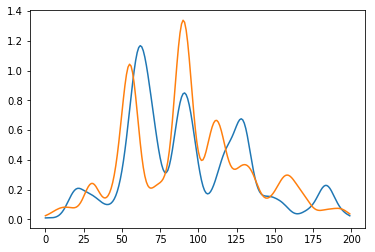

In [4]:
figure()
plot((data_gen.mean_A()/data_gen.n_A).numpy())
plot((data_gen.mean_B()/data_gen.n_B).numpy())

In [5]:
class VFE_1D_GPMM_Chained(torch.nn.Module):
    def __init__(self, U0, U1, F, Ntotal, Nmc = 100, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        f = Vector('f')
        m0 = Vector('m0')
        λ0 = Vector('λ0')
        u0 = Vector('u0')
        K0 = Kernel('K0')
        m1 = Vector('m1')
        λ1 = Vector('λ1')
        u1 = Vector('u1')
        K1 = Kernel('K1')
        y = Vector('y')
        X0 = Matrix('X0')
        X1 = Matrix('X1')
        Ntotal = Constant(Ntotal)
        Nmc = Constant(Nmc)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl_1D(K0, u0, λ0, m0, jitter) + kl_1D(K1, u1, λ1, m1, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        m0f = weighted_1D_mean(K0, u0, f, m0, X0)
        m1f = weighted_1D_mean(K1, u1, f, m1, X1)
        var0f = weighted_var_1D_diag(K0, u0, f, λ0, X0, jitter)
        var1f = weighted_var_1D_diag(K1, u1, f, λ1, X1, jitter)
        
        ### Gaussian Likelihood in f-space ###
        ϵ0 = StdNormalSample(m0f,Nmc)
        ϵ1 = StdNormalSample(m1f,Nmc)
        z0 = Sqrt(var0f)*ϵ0 + m0f
        z1 = Sqrt(var1f)*ϵ1 + m1f
        z = z0 + z1
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        m0f = mean_1D(K0, u0, f, m0)
        m1f = mean_1D(K1, u1, f, m1)
        graph = expr2graph(Label(String("mean0_pred"), m0f))
        self._mean0_pred = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("mean1_pred"), m1f))
        self._mean1_pred = graph2ast(graph, compiled=True, debug=False)
        var0f = var_1D_diag(K0, u0, f, λ0, jitter)
        var1f = var_1D_diag(K1, u1, f, λ1, jitter)
        graph = expr2graph(Label(String("var0_pred"), var0f))
        self._var0_pred = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("var1_pred"), var1f))
        self._var1_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm0': torch.nn.Parameter(torch.randn((U0,1),dtype=self.dtype)/(U0)),
                'm1': torch.nn.Parameter(torch.randn((U1,1),dtype=self.dtype)/(U1)),
                'λ0': torch.nn.Parameter(5*torch.ones((U0,1),dtype=self.dtype)),
                'λ1': torch.nn.Parameter(5*torch.ones((U1,1),dtype=self.dtype)),
            })
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                'u1': torch.nn.Parameter(torch.linspace(-1,1,U1,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(0.,dtype=self.dtype), requires_grad=False),
                'f': torch.nn.Parameter(torch.linspace(-1,1,F,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_K = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), transforms=[self._makepos, self._makepos]),
                'K1': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), transforms=[self._makepos, self._makepos]),
                })
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X0, X1):
        leaves = {
            'y': y,
            'X0': X0,
            'X1': X1,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X0, X1):
        leaves = {
            'y': y,
            'X0': X0,
            'X1': X1,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean0(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean0_pred(**leaves)
        return result.mean0_pred
    def predict_var0(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var0_pred(**leaves)
        return result.var0_pred
    def predict_mean1(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean1_pred(**leaves)
        return result.mean1_pred
    def predict_var1(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var1_pred(**leaves)
        return result.var1_pred

In [6]:
m = VFE_1D_GPMM_Chained(50,50,200,100000,std_lik_init=2.0,lenscale_init=0.05)
m.cuda()
optimizer = torch.optim.Adam(m.parameters(),lr=1e-2)
epochs = 2000
scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(X,Z,yc)
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_K.K0._lengthscale_storage': m._makepos,
                          'stored_K.K0._amplitude_storage': m._makepos,
                          'stored_K.K1._lengthscale_storage': m._makepos,
                          'stored_K.K1._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    d = DataLoader(dataset=data, shuffle=True, batch_size=5000)
    for Xb,Zb,yb in d:
        ybc, Xbc, Zbc = yb.cuda(), Xb.cuda(), Zb.cuda()
        optimizer.zero_grad()
        loss = m.loss(ybc,Xbc,Zbc)
        loss.backward()
        optimizer.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    scheduler.step()
    print(Logger.report("epoch {:d}: ".format(i)))

epoch 0: hyper_params.std_lik: 1.8262, stored_K.K0._lengthscale_storage: 0.0439187, stored_K.K0._amplitude_storage: 0.902033, stored_K.K1._lengthscale_storage: 0.0451187, stored_K.K1._amplitude_storage: 0.916819, loss: 161979, step_size: 0.01, 
epoch 1: hyper_params.std_lik: 1.65386, stored_K.K0._lengthscale_storage: 0.038828, stored_K.K0._amplitude_storage: 0.82206, stored_K.K1._lengthscale_storage: 0.0403737, stored_K.K1._amplitude_storage: 0.842708, loss: 152530, step_size: 0.01, 
epoch 2: hyper_params.std_lik: 1.48518, stored_K.K0._lengthscale_storage: 0.033948, stored_K.K0._amplitude_storage: 0.738439, stored_K.K1._lengthscale_storage: 0.0356521, stored_K.K1._amplitude_storage: 0.762636, loss: 142110, step_size: 0.01, 
epoch 3: hyper_params.std_lik: 1.32155, stored_K.K0._lengthscale_storage: 0.0293599, stored_K.K0._amplitude_storage: 0.653024, stored_K.K1._lengthscale_storage: 0.031044, stored_K.K1._amplitude_storage: 0.678223, loss: 130740, step_size: 0.01, 
epoch 4: hyper_params

epoch 33: hyper_params.std_lik: 0.105576, stored_K.K0._lengthscale_storage: 0.0402525, stored_K.K0._amplitude_storage: 0.0257953, stored_K.K1._lengthscale_storage: 0.0390663, stored_K.K1._amplitude_storage: 0.0264096, loss: -83877.2, step_size: 0.01, 
epoch 34: hyper_params.std_lik: 0.1049, stored_K.K0._lengthscale_storage: 0.0411804, stored_K.K0._amplitude_storage: 0.0254475, stored_K.K1._lengthscale_storage: 0.0401449, stored_K.K1._amplitude_storage: 0.0261021, loss: -83309, step_size: 0.01, 
epoch 35: hyper_params.std_lik: 0.104341, stored_K.K0._lengthscale_storage: 0.0421958, stored_K.K0._amplitude_storage: 0.0252374, stored_K.K1._lengthscale_storage: 0.041166, stored_K.K1._amplitude_storage: 0.0257988, loss: -84672, step_size: 0.01, 
epoch 36: hyper_params.std_lik: 0.10389, stored_K.K0._lengthscale_storage: 0.0427643, stored_K.K0._amplitude_storage: 0.0248664, stored_K.K1._lengthscale_storage: 0.041837, stored_K.K1._amplitude_storage: 0.0253837, loss: -84011.6, step_size: 0.01, 
e

epoch 66: hyper_params.std_lik: 0.10092, stored_K.K0._lengthscale_storage: 0.0537997, stored_K.K0._amplitude_storage: 0.021619, stored_K.K1._lengthscale_storage: 0.0546744, stored_K.K1._amplitude_storage: 0.021853, loss: -86044, step_size: 0.0095, 
epoch 67: hyper_params.std_lik: 0.100906, stored_K.K0._lengthscale_storage: 0.0539477, stored_K.K0._amplitude_storage: 0.0215518, stored_K.K1._lengthscale_storage: 0.0548834, stored_K.K1._amplitude_storage: 0.0218359, loss: -89853.6, step_size: 0.0095, 
epoch 68: hyper_params.std_lik: 0.100786, stored_K.K0._lengthscale_storage: 0.0541818, stored_K.K0._amplitude_storage: 0.0214985, stored_K.K1._lengthscale_storage: 0.0549827, stored_K.K1._amplitude_storage: 0.0217907, loss: -88215.5, step_size: 0.0095, 
epoch 69: hyper_params.std_lik: 0.100794, stored_K.K0._lengthscale_storage: 0.0544451, stored_K.K0._amplitude_storage: 0.0214774, stored_K.K1._lengthscale_storage: 0.0552492, stored_K.K1._amplitude_storage: 0.0218055, loss: -87687.7, step_size

epoch 99: hyper_params.std_lik: 0.100618, stored_K.K0._lengthscale_storage: 0.0582336, stored_K.K0._amplitude_storage: 0.0202382, stored_K.K1._lengthscale_storage: 0.0569014, stored_K.K1._amplitude_storage: 0.0211773, loss: -87724.4, step_size: 0.0095, 
epoch 100: hyper_params.std_lik: 0.100441, stored_K.K0._lengthscale_storage: 0.0583898, stored_K.K0._amplitude_storage: 0.0202257, stored_K.K1._lengthscale_storage: 0.0568609, stored_K.K1._amplitude_storage: 0.02114, loss: -87550, step_size: 0.0095, 
epoch 101: hyper_params.std_lik: 0.100383, stored_K.K0._lengthscale_storage: 0.0584607, stored_K.K0._amplitude_storage: 0.0201929, stored_K.K1._lengthscale_storage: 0.0568778, stored_K.K1._amplitude_storage: 0.0211292, loss: -87305.8, step_size: 0.009025, 
epoch 102: hyper_params.std_lik: 0.10039, stored_K.K0._lengthscale_storage: 0.0585614, stored_K.K0._amplitude_storage: 0.0201747, stored_K.K1._lengthscale_storage: 0.0569437, stored_K.K1._amplitude_storage: 0.0211427, loss: -89816.1, step

epoch 131: hyper_params.std_lik: 0.100177, stored_K.K0._lengthscale_storage: 0.0603906, stored_K.K0._amplitude_storage: 0.0195623, stored_K.K1._lengthscale_storage: 0.0574654, stored_K.K1._amplitude_storage: 0.0208872, loss: -87028.7, step_size: 0.009025, 
epoch 132: hyper_params.std_lik: 0.100079, stored_K.K0._lengthscale_storage: 0.060463, stored_K.K0._amplitude_storage: 0.0195525, stored_K.K1._lengthscale_storage: 0.0574379, stored_K.K1._amplitude_storage: 0.0208869, loss: -86256.7, step_size: 0.009025, 
epoch 133: hyper_params.std_lik: 0.100499, stored_K.K0._lengthscale_storage: 0.0605189, stored_K.K0._amplitude_storage: 0.0195504, stored_K.K1._lengthscale_storage: 0.0574005, stored_K.K1._amplitude_storage: 0.0208688, loss: -88027.1, step_size: 0.009025, 
epoch 134: hyper_params.std_lik: 0.100175, stored_K.K0._lengthscale_storage: 0.0605994, stored_K.K0._amplitude_storage: 0.0195379, stored_K.K1._lengthscale_storage: 0.0574412, stored_K.K1._amplitude_storage: 0.0208851, loss: -8897

epoch 163: hyper_params.std_lik: 0.100191, stored_K.K0._lengthscale_storage: 0.061712, stored_K.K0._amplitude_storage: 0.0192562, stored_K.K1._lengthscale_storage: 0.057482, stored_K.K1._amplitude_storage: 0.020808, loss: -85926.9, step_size: 0.00857375, 
epoch 164: hyper_params.std_lik: 0.100633, stored_K.K0._lengthscale_storage: 0.0614615, stored_K.K0._amplitude_storage: 0.0191559, stored_K.K1._lengthscale_storage: 0.0573679, stored_K.K1._amplitude_storage: 0.0207588, loss: -88991.2, step_size: 0.00857375, 
epoch 165: hyper_params.std_lik: 0.0999551, stored_K.K0._lengthscale_storage: 0.0616483, stored_K.K0._amplitude_storage: 0.0192001, stored_K.K1._lengthscale_storage: 0.0575133, stored_K.K1._amplitude_storage: 0.0208039, loss: -87675.6, step_size: 0.00857375, 
epoch 166: hyper_params.std_lik: 0.100095, stored_K.K0._lengthscale_storage: 0.0616708, stored_K.K0._amplitude_storage: 0.0191923, stored_K.K1._lengthscale_storage: 0.0573955, stored_K.K1._amplitude_storage: 0.0207588, loss: 

epoch 195: hyper_params.std_lik: 0.10027, stored_K.K0._lengthscale_storage: 0.0623002, stored_K.K0._amplitude_storage: 0.0190057, stored_K.K1._lengthscale_storage: 0.057462, stored_K.K1._amplitude_storage: 0.0205885, loss: -88849.5, step_size: 0.00857375, 
epoch 196: hyper_params.std_lik: 0.100392, stored_K.K0._lengthscale_storage: 0.0623775, stored_K.K0._amplitude_storage: 0.0190113, stored_K.K1._lengthscale_storage: 0.0574497, stored_K.K1._amplitude_storage: 0.0205782, loss: -87992.3, step_size: 0.00857375, 
epoch 197: hyper_params.std_lik: 0.0993811, stored_K.K0._lengthscale_storage: 0.0622585, stored_K.K0._amplitude_storage: 0.0189708, stored_K.K1._lengthscale_storage: 0.0575003, stored_K.K1._amplitude_storage: 0.0205953, loss: -87942.2, step_size: 0.00857375, 
epoch 198: hyper_params.std_lik: 0.100675, stored_K.K0._lengthscale_storage: 0.0623371, stored_K.K0._amplitude_storage: 0.0189869, stored_K.K1._lengthscale_storage: 0.057565, stored_K.K1._amplitude_storage: 0.0206055, loss: 

epoch 227: hyper_params.std_lik: 0.0999489, stored_K.K0._lengthscale_storage: 0.0627841, stored_K.K0._amplitude_storage: 0.0188558, stored_K.K1._lengthscale_storage: 0.0577469, stored_K.K1._amplitude_storage: 0.0204185, loss: -87973.7, step_size: 0.00814506, 
epoch 228: hyper_params.std_lik: 0.10003, stored_K.K0._lengthscale_storage: 0.0629121, stored_K.K0._amplitude_storage: 0.0188825, stored_K.K1._lengthscale_storage: 0.0577148, stored_K.K1._amplitude_storage: 0.0203939, loss: -87805.6, step_size: 0.00814506, 
epoch 229: hyper_params.std_lik: 0.10001, stored_K.K0._lengthscale_storage: 0.0629049, stored_K.K0._amplitude_storage: 0.0188736, stored_K.K1._lengthscale_storage: 0.0577463, stored_K.K1._amplitude_storage: 0.0203995, loss: -87583.3, step_size: 0.00814506, 
epoch 230: hyper_params.std_lik: 0.100024, stored_K.K0._lengthscale_storage: 0.062874, stored_K.K0._amplitude_storage: 0.0188583, stored_K.K1._lengthscale_storage: 0.0578014, stored_K.K1._amplitude_storage: 0.020415, loss: -

epoch 259: hyper_params.std_lik: 0.10073, stored_K.K0._lengthscale_storage: 0.0633023, stored_K.K0._amplitude_storage: 0.0187427, stored_K.K1._lengthscale_storage: 0.0578368, stored_K.K1._amplitude_storage: 0.0202236, loss: -88022, step_size: 0.00773781, 
epoch 260: hyper_params.std_lik: 0.101032, stored_K.K0._lengthscale_storage: 0.0632986, stored_K.K0._amplitude_storage: 0.0187345, stored_K.K1._lengthscale_storage: 0.0577792, stored_K.K1._amplitude_storage: 0.020196, loss: -87459.2, step_size: 0.00773781, 
epoch 261: hyper_params.std_lik: 0.0997531, stored_K.K0._lengthscale_storage: 0.0633848, stored_K.K0._amplitude_storage: 0.0187587, stored_K.K1._lengthscale_storage: 0.057845, stored_K.K1._amplitude_storage: 0.0202103, loss: -88632.7, step_size: 0.00773781, 
epoch 262: hyper_params.std_lik: 0.100428, stored_K.K0._lengthscale_storage: 0.063397, stored_K.K0._amplitude_storage: 0.018752, stored_K.K1._lengthscale_storage: 0.0578462, stored_K.K1._amplitude_storage: 0.0202052, loss: -863

epoch 291: hyper_params.std_lik: 0.100428, stored_K.K0._lengthscale_storage: 0.06347, stored_K.K0._amplitude_storage: 0.0186073, stored_K.K1._lengthscale_storage: 0.0580674, stored_K.K1._amplitude_storage: 0.0200714, loss: -89079.1, step_size: 0.00773781, 
epoch 292: hyper_params.std_lik: 0.100083, stored_K.K0._lengthscale_storage: 0.0634912, stored_K.K0._amplitude_storage: 0.0186103, stored_K.K1._lengthscale_storage: 0.0580727, stored_K.K1._amplitude_storage: 0.0200723, loss: -88623.5, step_size: 0.00773781, 
epoch 293: hyper_params.std_lik: 0.100003, stored_K.K0._lengthscale_storage: 0.0633575, stored_K.K0._amplitude_storage: 0.0185642, stored_K.K1._lengthscale_storage: 0.0580447, stored_K.K1._amplitude_storage: 0.0200614, loss: -86374.9, step_size: 0.00773781, 
epoch 294: hyper_params.std_lik: 0.099552, stored_K.K0._lengthscale_storage: 0.0633997, stored_K.K0._amplitude_storage: 0.018583, stored_K.K1._lengthscale_storage: 0.0581779, stored_K.K1._amplitude_storage: 0.0201077, loss: -

epoch 323: hyper_params.std_lik: 0.0990891, stored_K.K0._lengthscale_storage: 0.0633522, stored_K.K0._amplitude_storage: 0.0184674, stored_K.K1._lengthscale_storage: 0.0581521, stored_K.K1._amplitude_storage: 0.0199377, loss: -89349.4, step_size: 0.00735092, 
epoch 324: hyper_params.std_lik: 0.099446, stored_K.K0._lengthscale_storage: 0.0633091, stored_K.K0._amplitude_storage: 0.0184471, stored_K.K1._lengthscale_storage: 0.0581125, stored_K.K1._amplitude_storage: 0.0199184, loss: -89279.9, step_size: 0.00735092, 
epoch 325: hyper_params.std_lik: 0.100759, stored_K.K0._lengthscale_storage: 0.0632852, stored_K.K0._amplitude_storage: 0.0184423, stored_K.K1._lengthscale_storage: 0.058106, stored_K.K1._amplitude_storage: 0.0198978, loss: -87751.4, step_size: 0.00735092, 
epoch 326: hyper_params.std_lik: 0.0994582, stored_K.K0._lengthscale_storage: 0.0632473, stored_K.K0._amplitude_storage: 0.0184214, stored_K.K1._lengthscale_storage: 0.0581911, stored_K.K1._amplitude_storage: 0.0199247, los

epoch 355: hyper_params.std_lik: 0.100249, stored_K.K0._lengthscale_storage: 0.0635331, stored_K.K0._amplitude_storage: 0.0183463, stored_K.K1._lengthscale_storage: 0.0583019, stored_K.K1._amplitude_storage: 0.0197973, loss: -88546.7, step_size: 0.00698337, 
epoch 356: hyper_params.std_lik: 0.0998807, stored_K.K0._lengthscale_storage: 0.0635288, stored_K.K0._amplitude_storage: 0.0183406, stored_K.K1._lengthscale_storage: 0.058291, stored_K.K1._amplitude_storage: 0.0197887, loss: -89320.2, step_size: 0.00698337, 
epoch 357: hyper_params.std_lik: 0.100872, stored_K.K0._lengthscale_storage: 0.0636049, stored_K.K0._amplitude_storage: 0.0183589, stored_K.K1._lengthscale_storage: 0.0583921, stored_K.K1._amplitude_storage: 0.0198207, loss: -87441.3, step_size: 0.00698337, 
epoch 358: hyper_params.std_lik: 0.0995225, stored_K.K0._lengthscale_storage: 0.0635396, stored_K.K0._amplitude_storage: 0.0183285, stored_K.K1._lengthscale_storage: 0.0583327, stored_K.K1._amplitude_storage: 0.0198023, los

epoch 387: hyper_params.std_lik: 0.100071, stored_K.K0._lengthscale_storage: 0.0639629, stored_K.K0._amplitude_storage: 0.0182995, stored_K.K1._lengthscale_storage: 0.0581961, stored_K.K1._amplitude_storage: 0.0196726, loss: -86164.1, step_size: 0.00698337, 
epoch 388: hyper_params.std_lik: 0.0994954, stored_K.K0._lengthscale_storage: 0.0639394, stored_K.K0._amplitude_storage: 0.018286, stored_K.K1._lengthscale_storage: 0.0580991, stored_K.K1._amplitude_storage: 0.0196455, loss: -87871.8, step_size: 0.00698337, 
epoch 389: hyper_params.std_lik: 0.100436, stored_K.K0._lengthscale_storage: 0.0638414, stored_K.K0._amplitude_storage: 0.0182495, stored_K.K1._lengthscale_storage: 0.0580755, stored_K.K1._amplitude_storage: 0.0196238, loss: -88806.3, step_size: 0.00698337, 
epoch 390: hyper_params.std_lik: 0.0990396, stored_K.K0._lengthscale_storage: 0.063795, stored_K.K0._amplitude_storage: 0.0182414, stored_K.K1._lengthscale_storage: 0.0580696, stored_K.K1._amplitude_storage: 0.0196284, loss

epoch 419: hyper_params.std_lik: 0.100043, stored_K.K0._lengthscale_storage: 0.0640594, stored_K.K0._amplitude_storage: 0.0181967, stored_K.K1._lengthscale_storage: 0.0578826, stored_K.K1._amplitude_storage: 0.0195219, loss: -87151.8, step_size: 0.0066342, 
epoch 420: hyper_params.std_lik: 0.100478, stored_K.K0._lengthscale_storage: 0.0641636, stored_K.K0._amplitude_storage: 0.0182167, stored_K.K1._lengthscale_storage: 0.0579556, stored_K.K1._amplitude_storage: 0.0195439, loss: -88628.9, step_size: 0.0066342, 
epoch 421: hyper_params.std_lik: 0.0995169, stored_K.K0._lengthscale_storage: 0.0641125, stored_K.K0._amplitude_storage: 0.0182016, stored_K.K1._lengthscale_storage: 0.0579397, stored_K.K1._amplitude_storage: 0.0195307, loss: -88382.2, step_size: 0.0066342, 
epoch 422: hyper_params.std_lik: 0.100579, stored_K.K0._lengthscale_storage: 0.0641491, stored_K.K0._amplitude_storage: 0.0182077, stored_K.K1._lengthscale_storage: 0.0579213, stored_K.K1._amplitude_storage: 0.01953, loss: -8

epoch 451: hyper_params.std_lik: 0.099718, stored_K.K0._lengthscale_storage: 0.0642165, stored_K.K0._amplitude_storage: 0.0181305, stored_K.K1._lengthscale_storage: 0.0579953, stored_K.K1._amplitude_storage: 0.0194588, loss: -87393.3, step_size: 0.00630249, 
epoch 452: hyper_params.std_lik: 0.100753, stored_K.K0._lengthscale_storage: 0.0643976, stored_K.K0._amplitude_storage: 0.018171, stored_K.K1._lengthscale_storage: 0.0580487, stored_K.K1._amplitude_storage: 0.0194784, loss: -87757.9, step_size: 0.00630249, 
epoch 453: hyper_params.std_lik: 0.0999607, stored_K.K0._lengthscale_storage: 0.0643743, stored_K.K0._amplitude_storage: 0.0181623, stored_K.K1._lengthscale_storage: 0.0579793, stored_K.K1._amplitude_storage: 0.0194525, loss: -87342.8, step_size: 0.00630249, 
epoch 454: hyper_params.std_lik: 0.0988963, stored_K.K0._lengthscale_storage: 0.0643043, stored_K.K0._amplitude_storage: 0.0181455, stored_K.K1._lengthscale_storage: 0.0580451, stored_K.K1._amplitude_storage: 0.0194716, los

epoch 483: hyper_params.std_lik: 0.100578, stored_K.K0._lengthscale_storage: 0.0645623, stored_K.K0._amplitude_storage: 0.0181386, stored_K.K1._lengthscale_storage: 0.0579033, stored_K.K1._amplitude_storage: 0.0195143, loss: -88544.7, step_size: 0.00630249, 
epoch 484: hyper_params.std_lik: 0.100221, stored_K.K0._lengthscale_storage: 0.0644922, stored_K.K0._amplitude_storage: 0.0181189, stored_K.K1._lengthscale_storage: 0.0578344, stored_K.K1._amplitude_storage: 0.0194993, loss: -87588, step_size: 0.00630249, 
epoch 485: hyper_params.std_lik: 0.0996272, stored_K.K0._lengthscale_storage: 0.0644632, stored_K.K0._amplitude_storage: 0.0181102, stored_K.K1._lengthscale_storage: 0.057864, stored_K.K1._amplitude_storage: 0.0195091, loss: -89699.1, step_size: 0.00630249, 
epoch 486: hyper_params.std_lik: 0.101075, stored_K.K0._lengthscale_storage: 0.0644832, stored_K.K0._amplitude_storage: 0.018109, stored_K.K1._lengthscale_storage: 0.0579065, stored_K.K1._amplitude_storage: 0.0195294, loss: -

epoch 515: hyper_params.std_lik: 0.0997095, stored_K.K0._lengthscale_storage: 0.0645573, stored_K.K0._amplitude_storage: 0.018067, stored_K.K1._lengthscale_storage: 0.057873, stored_K.K1._amplitude_storage: 0.0194655, loss: -86616.6, step_size: 0.00598737, 
epoch 516: hyper_params.std_lik: 0.0990951, stored_K.K0._lengthscale_storage: 0.0646861, stored_K.K0._amplitude_storage: 0.0181013, stored_K.K1._lengthscale_storage: 0.0579085, stored_K.K1._amplitude_storage: 0.0194703, loss: -87749.1, step_size: 0.00598737, 
epoch 517: hyper_params.std_lik: 0.100506, stored_K.K0._lengthscale_storage: 0.0646775, stored_K.K0._amplitude_storage: 0.0180874, stored_K.K1._lengthscale_storage: 0.0579661, stored_K.K1._amplitude_storage: 0.0194877, loss: -87260.5, step_size: 0.00598737, 
epoch 518: hyper_params.std_lik: 0.100105, stored_K.K0._lengthscale_storage: 0.064564, stored_K.K0._amplitude_storage: 0.01806, stored_K.K1._lengthscale_storage: 0.0579128, stored_K.K1._amplitude_storage: 0.0194687, loss: -

epoch 547: hyper_params.std_lik: 0.100788, stored_K.K0._lengthscale_storage: 0.064694, stored_K.K0._amplitude_storage: 0.0180523, stored_K.K1._lengthscale_storage: 0.0579908, stored_K.K1._amplitude_storage: 0.019392, loss: -87553, step_size: 0.00598737, 
epoch 548: hyper_params.std_lik: 0.0998164, stored_K.K0._lengthscale_storage: 0.0646454, stored_K.K0._amplitude_storage: 0.0180379, stored_K.K1._lengthscale_storage: 0.0579503, stored_K.K1._amplitude_storage: 0.0193744, loss: -86286.9, step_size: 0.00598737, 
epoch 549: hyper_params.std_lik: 0.0995654, stored_K.K0._lengthscale_storage: 0.0648039, stored_K.K0._amplitude_storage: 0.0180825, stored_K.K1._lengthscale_storage: 0.0579686, stored_K.K1._amplitude_storage: 0.0193768, loss: -88350.9, step_size: 0.00598737, 
epoch 550: hyper_params.std_lik: 0.0996959, stored_K.K0._lengthscale_storage: 0.0647736, stored_K.K0._amplitude_storage: 0.0180711, stored_K.K1._lengthscale_storage: 0.0579953, stored_K.K1._amplitude_storage: 0.0193832, loss:

epoch 579: hyper_params.std_lik: 0.0998014, stored_K.K0._lengthscale_storage: 0.064888, stored_K.K0._amplitude_storage: 0.0180576, stored_K.K1._lengthscale_storage: 0.0580312, stored_K.K1._amplitude_storage: 0.0193851, loss: -89679.6, step_size: 0.005688, 
epoch 580: hyper_params.std_lik: 0.0999163, stored_K.K0._lengthscale_storage: 0.0648173, stored_K.K0._amplitude_storage: 0.0180376, stored_K.K1._lengthscale_storage: 0.05806, stored_K.K1._amplitude_storage: 0.0194007, loss: -87646.4, step_size: 0.005688, 
epoch 581: hyper_params.std_lik: 0.100011, stored_K.K0._lengthscale_storage: 0.0648644, stored_K.K0._amplitude_storage: 0.0180471, stored_K.K1._lengthscale_storage: 0.058065, stored_K.K1._amplitude_storage: 0.0194071, loss: -88304.6, step_size: 0.005688, 
epoch 582: hyper_params.std_lik: 0.0995115, stored_K.K0._lengthscale_storage: 0.0648633, stored_K.K0._amplitude_storage: 0.0180481, stored_K.K1._lengthscale_storage: 0.0581353, stored_K.K1._amplitude_storage: 0.0194221, loss: -8839

epoch 611: hyper_params.std_lik: 0.100393, stored_K.K0._lengthscale_storage: 0.0650352, stored_K.K0._amplitude_storage: 0.0180516, stored_K.K1._lengthscale_storage: 0.0580524, stored_K.K1._amplitude_storage: 0.0194356, loss: -87584.5, step_size: 0.0054036, 
epoch 612: hyper_params.std_lik: 0.100084, stored_K.K0._lengthscale_storage: 0.0649365, stored_K.K0._amplitude_storage: 0.0180218, stored_K.K1._lengthscale_storage: 0.0580208, stored_K.K1._amplitude_storage: 0.0194293, loss: -88156, step_size: 0.0054036, 
epoch 613: hyper_params.std_lik: 0.0998381, stored_K.K0._lengthscale_storage: 0.0649334, stored_K.K0._amplitude_storage: 0.018023, stored_K.K1._lengthscale_storage: 0.0579888, stored_K.K1._amplitude_storage: 0.0194176, loss: -88077.5, step_size: 0.0054036, 
epoch 614: hyper_params.std_lik: 0.100187, stored_K.K0._lengthscale_storage: 0.0650029, stored_K.K0._amplitude_storage: 0.0180369, stored_K.K1._lengthscale_storage: 0.0580385, stored_K.K1._amplitude_storage: 0.0194312, loss: -87

epoch 643: hyper_params.std_lik: 0.100029, stored_K.K0._lengthscale_storage: 0.0650232, stored_K.K0._amplitude_storage: 0.0180144, stored_K.K1._lengthscale_storage: 0.057983, stored_K.K1._amplitude_storage: 0.0194335, loss: -88003.1, step_size: 0.0054036, 
epoch 644: hyper_params.std_lik: 0.0996602, stored_K.K0._lengthscale_storage: 0.0649391, stored_K.K0._amplitude_storage: 0.0179934, stored_K.K1._lengthscale_storage: 0.0579194, stored_K.K1._amplitude_storage: 0.0194129, loss: -87333, step_size: 0.0054036, 
epoch 645: hyper_params.std_lik: 0.100194, stored_K.K0._lengthscale_storage: 0.0649508, stored_K.K0._amplitude_storage: 0.0179884, stored_K.K1._lengthscale_storage: 0.057876, stored_K.K1._amplitude_storage: 0.0193935, loss: -87412.4, step_size: 0.0054036, 
epoch 646: hyper_params.std_lik: 0.099792, stored_K.K0._lengthscale_storage: 0.0650943, stored_K.K0._amplitude_storage: 0.0180335, stored_K.K1._lengthscale_storage: 0.0579797, stored_K.K1._amplitude_storage: 0.0194291, loss: -875

epoch 675: hyper_params.std_lik: 0.0998908, stored_K.K0._lengthscale_storage: 0.0650458, stored_K.K0._amplitude_storage: 0.0179864, stored_K.K1._lengthscale_storage: 0.0578732, stored_K.K1._amplitude_storage: 0.0194164, loss: -86744.2, step_size: 0.00513342, 
epoch 676: hyper_params.std_lik: 0.0992678, stored_K.K0._lengthscale_storage: 0.0650393, stored_K.K0._amplitude_storage: 0.0179851, stored_K.K1._lengthscale_storage: 0.0579043, stored_K.K1._amplitude_storage: 0.0194215, loss: -88632.3, step_size: 0.00513342, 
epoch 677: hyper_params.std_lik: 0.0996832, stored_K.K0._lengthscale_storage: 0.0650569, stored_K.K0._amplitude_storage: 0.0179859, stored_K.K1._lengthscale_storage: 0.0578586, stored_K.K1._amplitude_storage: 0.019413, loss: -87759.9, step_size: 0.00513342, 
epoch 678: hyper_params.std_lik: 0.100474, stored_K.K0._lengthscale_storage: 0.0651424, stored_K.K0._amplitude_storage: 0.0180116, stored_K.K1._lengthscale_storage: 0.0578441, stored_K.K1._amplitude_storage: 0.0194033, lo

epoch 707: hyper_params.std_lik: 0.0996639, stored_K.K0._lengthscale_storage: 0.0651654, stored_K.K0._amplitude_storage: 0.017981, stored_K.K1._lengthscale_storage: 0.0577885, stored_K.K1._amplitude_storage: 0.0193856, loss: -89618.3, step_size: 0.00487675, 
epoch 708: hyper_params.std_lik: 0.100215, stored_K.K0._lengthscale_storage: 0.0651402, stored_K.K0._amplitude_storage: 0.0179759, stored_K.K1._lengthscale_storage: 0.057842, stored_K.K1._amplitude_storage: 0.0194076, loss: -87202.8, step_size: 0.00487675, 
epoch 709: hyper_params.std_lik: 0.0997327, stored_K.K0._lengthscale_storage: 0.065262, stored_K.K0._amplitude_storage: 0.0180073, stored_K.K1._lengthscale_storage: 0.057889, stored_K.K1._amplitude_storage: 0.0194214, loss: -87129.2, step_size: 0.00487675, 
epoch 710: hyper_params.std_lik: 0.0997579, stored_K.K0._lengthscale_storage: 0.0651511, stored_K.K0._amplitude_storage: 0.017976, stored_K.K1._lengthscale_storage: 0.0578345, stored_K.K1._amplitude_storage: 0.019405, loss: -

epoch 739: hyper_params.std_lik: 0.100221, stored_K.K0._lengthscale_storage: 0.0653111, stored_K.K0._amplitude_storage: 0.0179888, stored_K.K1._lengthscale_storage: 0.0578055, stored_K.K1._amplitude_storage: 0.01937, loss: -88411.7, step_size: 0.00487675, 
epoch 740: hyper_params.std_lik: 0.0997605, stored_K.K0._lengthscale_storage: 0.0652364, stored_K.K0._amplitude_storage: 0.0179681, stored_K.K1._lengthscale_storage: 0.0577966, stored_K.K1._amplitude_storage: 0.0193676, loss: -85943.8, step_size: 0.00487675, 
epoch 741: hyper_params.std_lik: 0.0991659, stored_K.K0._lengthscale_storage: 0.0652461, stored_K.K0._amplitude_storage: 0.0179719, stored_K.K1._lengthscale_storage: 0.0578202, stored_K.K1._amplitude_storage: 0.0193742, loss: -89081.3, step_size: 0.00487675, 
epoch 742: hyper_params.std_lik: 0.100273, stored_K.K0._lengthscale_storage: 0.0651894, stored_K.K0._amplitude_storage: 0.0179548, stored_K.K1._lengthscale_storage: 0.0578243, stored_K.K1._amplitude_storage: 0.0193744, loss

epoch 771: hyper_params.std_lik: 0.100226, stored_K.K0._lengthscale_storage: 0.0653369, stored_K.K0._amplitude_storage: 0.0179591, stored_K.K1._lengthscale_storage: 0.0578633, stored_K.K1._amplitude_storage: 0.0193911, loss: -89266.1, step_size: 0.00463291, 
epoch 772: hyper_params.std_lik: 0.099842, stored_K.K0._lengthscale_storage: 0.065312, stored_K.K0._amplitude_storage: 0.0179533, stored_K.K1._lengthscale_storage: 0.0578035, stored_K.K1._amplitude_storage: 0.0193662, loss: -88416.1, step_size: 0.00463291, 
epoch 773: hyper_params.std_lik: 0.0994585, stored_K.K0._lengthscale_storage: 0.0653182, stored_K.K0._amplitude_storage: 0.017951, stored_K.K1._lengthscale_storage: 0.0577914, stored_K.K1._amplitude_storage: 0.0193631, loss: -88454.8, step_size: 0.00463291, 
epoch 774: hyper_params.std_lik: 0.0999064, stored_K.K0._lengthscale_storage: 0.0654117, stored_K.K0._amplitude_storage: 0.0179787, stored_K.K1._lengthscale_storage: 0.0577179, stored_K.K1._amplitude_storage: 0.0193369, loss

epoch 803: hyper_params.std_lik: 0.0996465, stored_K.K0._lengthscale_storage: 0.0653869, stored_K.K0._amplitude_storage: 0.0179396, stored_K.K1._lengthscale_storage: 0.0577818, stored_K.K1._amplitude_storage: 0.0193519, loss: -88011.5, step_size: 0.00440127, 
epoch 804: hyper_params.std_lik: 0.100324, stored_K.K0._lengthscale_storage: 0.0653591, stored_K.K0._amplitude_storage: 0.0179296, stored_K.K1._lengthscale_storage: 0.0578339, stored_K.K1._amplitude_storage: 0.0193655, loss: -87062.7, step_size: 0.00440127, 
epoch 805: hyper_params.std_lik: 0.100255, stored_K.K0._lengthscale_storage: 0.0653594, stored_K.K0._amplitude_storage: 0.0179293, stored_K.K1._lengthscale_storage: 0.0577928, stored_K.K1._amplitude_storage: 0.0193558, loss: -87626.5, step_size: 0.00440127, 
epoch 806: hyper_params.std_lik: 0.0996798, stored_K.K0._lengthscale_storage: 0.0653629, stored_K.K0._amplitude_storage: 0.0179253, stored_K.K1._lengthscale_storage: 0.0578253, stored_K.K1._amplitude_storage: 0.0193663, lo

epoch 835: hyper_params.std_lik: 0.0999093, stored_K.K0._lengthscale_storage: 0.0654211, stored_K.K0._amplitude_storage: 0.017916, stored_K.K1._lengthscale_storage: 0.0577255, stored_K.K1._amplitude_storage: 0.0193601, loss: -87903.5, step_size: 0.00440127, 
epoch 836: hyper_params.std_lik: 0.0992949, stored_K.K0._lengthscale_storage: 0.0655024, stored_K.K0._amplitude_storage: 0.0179409, stored_K.K1._lengthscale_storage: 0.0577661, stored_K.K1._amplitude_storage: 0.0193727, loss: -88390.3, step_size: 0.00440127, 
epoch 837: hyper_params.std_lik: 0.100048, stored_K.K0._lengthscale_storage: 0.0654996, stored_K.K0._amplitude_storage: 0.0179377, stored_K.K1._lengthscale_storage: 0.0576642, stored_K.K1._amplitude_storage: 0.0193436, loss: -87330.6, step_size: 0.00440127, 
epoch 838: hyper_params.std_lik: 0.0998547, stored_K.K0._lengthscale_storage: 0.0655119, stored_K.K0._amplitude_storage: 0.0179397, stored_K.K1._lengthscale_storage: 0.0576567, stored_K.K1._amplitude_storage: 0.0193421, lo

epoch 867: hyper_params.std_lik: 0.100082, stored_K.K0._lengthscale_storage: 0.065591, stored_K.K0._amplitude_storage: 0.0179359, stored_K.K1._lengthscale_storage: 0.0575189, stored_K.K1._amplitude_storage: 0.0193654, loss: -87934.4, step_size: 0.0041812, 
epoch 868: hyper_params.std_lik: 0.0999102, stored_K.K0._lengthscale_storage: 0.0655274, stored_K.K0._amplitude_storage: 0.0179182, stored_K.K1._lengthscale_storage: 0.057555, stored_K.K1._amplitude_storage: 0.0193805, loss: -88740.1, step_size: 0.0041812, 
epoch 869: hyper_params.std_lik: 0.0994623, stored_K.K0._lengthscale_storage: 0.0655109, stored_K.K0._amplitude_storage: 0.0179134, stored_K.K1._lengthscale_storage: 0.0575044, stored_K.K1._amplitude_storage: 0.0193617, loss: -88190.2, step_size: 0.0041812, 
epoch 870: hyper_params.std_lik: 0.100019, stored_K.K0._lengthscale_storage: 0.0656176, stored_K.K0._amplitude_storage: 0.0179414, stored_K.K1._lengthscale_storage: 0.0575595, stored_K.K1._amplitude_storage: 0.0193868, loss: -

epoch 899: hyper_params.std_lik: 0.10031, stored_K.K0._lengthscale_storage: 0.0656682, stored_K.K0._amplitude_storage: 0.0179213, stored_K.K1._lengthscale_storage: 0.0575139, stored_K.K1._amplitude_storage: 0.0194106, loss: -89303.2, step_size: 0.0041812, 
epoch 900: hyper_params.std_lik: 0.0998959, stored_K.K0._lengthscale_storage: 0.0656171, stored_K.K0._amplitude_storage: 0.017904, stored_K.K1._lengthscale_storage: 0.0575315, stored_K.K1._amplitude_storage: 0.0194177, loss: -87379.4, step_size: 0.0041812, 
epoch 901: hyper_params.std_lik: 0.100172, stored_K.K0._lengthscale_storage: 0.0656484, stored_K.K0._amplitude_storage: 0.01791, stored_K.K1._lengthscale_storage: 0.057501, stored_K.K1._amplitude_storage: 0.0194111, loss: -88325.4, step_size: 0.00397214, 
epoch 902: hyper_params.std_lik: 0.0995801, stored_K.K0._lengthscale_storage: 0.065629, stored_K.K0._amplitude_storage: 0.017907, stored_K.K1._lengthscale_storage: 0.0574701, stored_K.K1._amplitude_storage: 0.0194033, loss: -8768

epoch 931: hyper_params.std_lik: 0.100248, stored_K.K0._lengthscale_storage: 0.0656272, stored_K.K0._amplitude_storage: 0.0179011, stored_K.K1._lengthscale_storage: 0.0573884, stored_K.K1._amplitude_storage: 0.0194039, loss: -88825.5, step_size: 0.00397214, 
epoch 932: hyper_params.std_lik: 0.0995659, stored_K.K0._lengthscale_storage: 0.0656751, stored_K.K0._amplitude_storage: 0.0179168, stored_K.K1._lengthscale_storage: 0.0573795, stored_K.K1._amplitude_storage: 0.0194012, loss: -86450, step_size: 0.00397214, 
epoch 933: hyper_params.std_lik: 0.100101, stored_K.K0._lengthscale_storage: 0.0656833, stored_K.K0._amplitude_storage: 0.0179162, stored_K.K1._lengthscale_storage: 0.0574067, stored_K.K1._amplitude_storage: 0.0194124, loss: -88479.5, step_size: 0.00397214, 
epoch 934: hyper_params.std_lik: 0.099659, stored_K.K0._lengthscale_storage: 0.0655444, stored_K.K0._amplitude_storage: 0.0178813, stored_K.K1._lengthscale_storage: 0.0573947, stored_K.K1._amplitude_storage: 0.0194103, loss:

epoch 963: hyper_params.std_lik: 0.099777, stored_K.K0._lengthscale_storage: 0.0656092, stored_K.K0._amplitude_storage: 0.017914, stored_K.K1._lengthscale_storage: 0.0573506, stored_K.K1._amplitude_storage: 0.0194149, loss: -88410.1, step_size: 0.00377354, 
epoch 964: hyper_params.std_lik: 0.0997992, stored_K.K0._lengthscale_storage: 0.0655909, stored_K.K0._amplitude_storage: 0.0179076, stored_K.K1._lengthscale_storage: 0.0572913, stored_K.K1._amplitude_storage: 0.019395, loss: -87745.6, step_size: 0.00377354, 
epoch 965: hyper_params.std_lik: 0.100293, stored_K.K0._lengthscale_storage: 0.06561, stored_K.K0._amplitude_storage: 0.0179138, stored_K.K1._lengthscale_storage: 0.0572901, stored_K.K1._amplitude_storage: 0.0193937, loss: -89200.5, step_size: 0.00377354, 
epoch 966: hyper_params.std_lik: 0.0998324, stored_K.K0._lengthscale_storage: 0.0655978, stored_K.K0._amplitude_storage: 0.017907, stored_K.K1._lengthscale_storage: 0.057367, stored_K.K1._amplitude_storage: 0.0194173, loss: -8

epoch 995: hyper_params.std_lik: 0.0994809, stored_K.K0._lengthscale_storage: 0.0656096, stored_K.K0._amplitude_storage: 0.0179136, stored_K.K1._lengthscale_storage: 0.0573184, stored_K.K1._amplitude_storage: 0.0194136, loss: -87323.8, step_size: 0.00377354, 
epoch 996: hyper_params.std_lik: 0.0999555, stored_K.K0._lengthscale_storage: 0.0656533, stored_K.K0._amplitude_storage: 0.0179252, stored_K.K1._lengthscale_storage: 0.0573417, stored_K.K1._amplitude_storage: 0.019421, loss: -89003.9, step_size: 0.00377354, 
epoch 997: hyper_params.std_lik: 0.0996238, stored_K.K0._lengthscale_storage: 0.0656795, stored_K.K0._amplitude_storage: 0.0179304, stored_K.K1._lengthscale_storage: 0.057245, stored_K.K1._amplitude_storage: 0.0193895, loss: -87907.4, step_size: 0.00377354, 
epoch 998: hyper_params.std_lik: 0.100416, stored_K.K0._lengthscale_storage: 0.0656157, stored_K.K0._amplitude_storage: 0.017918, stored_K.K1._lengthscale_storage: 0.0572124, stored_K.K1._amplitude_storage: 0.0193807, loss

epoch 1027: hyper_params.std_lik: 0.100289, stored_K.K0._lengthscale_storage: 0.0656798, stored_K.K0._amplitude_storage: 0.0179245, stored_K.K1._lengthscale_storage: 0.0572053, stored_K.K1._amplitude_storage: 0.0194548, loss: -87109.2, step_size: 0.00358486, 
epoch 1028: hyper_params.std_lik: 0.099857, stored_K.K0._lengthscale_storage: 0.0655659, stored_K.K0._amplitude_storage: 0.0178949, stored_K.K1._lengthscale_storage: 0.0571753, stored_K.K1._amplitude_storage: 0.0194452, loss: -87949, step_size: 0.00358486, 
epoch 1029: hyper_params.std_lik: 0.10017, stored_K.K0._lengthscale_storage: 0.065668, stored_K.K0._amplitude_storage: 0.0179234, stored_K.K1._lengthscale_storage: 0.0571693, stored_K.K1._amplitude_storage: 0.0194478, loss: -87155.6, step_size: 0.00358486, 
epoch 1030: hyper_params.std_lik: 0.100076, stored_K.K0._lengthscale_storage: 0.0656151, stored_K.K0._amplitude_storage: 0.017906, stored_K.K1._lengthscale_storage: 0.0571523, stored_K.K1._amplitude_storage: 0.0194451, loss:

epoch 1059: hyper_params.std_lik: 0.100141, stored_K.K0._lengthscale_storage: 0.0656673, stored_K.K0._amplitude_storage: 0.0179112, stored_K.K1._lengthscale_storage: 0.0570351, stored_K.K1._amplitude_storage: 0.019466, loss: -88047.2, step_size: 0.00340562, 
epoch 1060: hyper_params.std_lik: 0.100075, stored_K.K0._lengthscale_storage: 0.0656564, stored_K.K0._amplitude_storage: 0.0179138, stored_K.K1._lengthscale_storage: 0.0569645, stored_K.K1._amplitude_storage: 0.0194445, loss: -87888.3, step_size: 0.00340562, 
epoch 1061: hyper_params.std_lik: 0.0994504, stored_K.K0._lengthscale_storage: 0.0656774, stored_K.K0._amplitude_storage: 0.0179165, stored_K.K1._lengthscale_storage: 0.0570589, stored_K.K1._amplitude_storage: 0.0194751, loss: -86607.5, step_size: 0.00340562, 
epoch 1062: hyper_params.std_lik: 0.099842, stored_K.K0._lengthscale_storage: 0.0656014, stored_K.K0._amplitude_storage: 0.0178964, stored_K.K1._lengthscale_storage: 0.0570542, stored_K.K1._amplitude_storage: 0.0194759, 

epoch 1091: hyper_params.std_lik: 0.099876, stored_K.K0._lengthscale_storage: 0.0657241, stored_K.K0._amplitude_storage: 0.0179217, stored_K.K1._lengthscale_storage: 0.0569392, stored_K.K1._amplitude_storage: 0.0194883, loss: -86984.1, step_size: 0.00340562, 
epoch 1092: hyper_params.std_lik: 0.0997616, stored_K.K0._lengthscale_storage: 0.0657021, stored_K.K0._amplitude_storage: 0.0179137, stored_K.K1._lengthscale_storage: 0.0569557, stored_K.K1._amplitude_storage: 0.0194873, loss: -88841.9, step_size: 0.00340562, 
epoch 1093: hyper_params.std_lik: 0.0999661, stored_K.K0._lengthscale_storage: 0.0657557, stored_K.K0._amplitude_storage: 0.0179257, stored_K.K1._lengthscale_storage: 0.0568755, stored_K.K1._amplitude_storage: 0.0194669, loss: -87182.9, step_size: 0.00340562, 
epoch 1094: hyper_params.std_lik: 0.0997578, stored_K.K0._lengthscale_storage: 0.0657308, stored_K.K0._amplitude_storage: 0.01792, stored_K.K1._lengthscale_storage: 0.0569947, stored_K.K1._amplitude_storage: 0.0195037,

epoch 1123: hyper_params.std_lik: 0.100004, stored_K.K0._lengthscale_storage: 0.065774, stored_K.K0._amplitude_storage: 0.0179199, stored_K.K1._lengthscale_storage: 0.0568466, stored_K.K1._amplitude_storage: 0.0194844, loss: -87035.9, step_size: 0.00323534, 
epoch 1124: hyper_params.std_lik: 0.099848, stored_K.K0._lengthscale_storage: 0.0656792, stored_K.K0._amplitude_storage: 0.0178945, stored_K.K1._lengthscale_storage: 0.0568067, stored_K.K1._amplitude_storage: 0.0194704, loss: -86759.9, step_size: 0.00323534, 
epoch 1125: hyper_params.std_lik: 0.0999769, stored_K.K0._lengthscale_storage: 0.0657881, stored_K.K0._amplitude_storage: 0.017927, stored_K.K1._lengthscale_storage: 0.0568715, stored_K.K1._amplitude_storage: 0.019496, loss: -88704.1, step_size: 0.00323534, 
epoch 1126: hyper_params.std_lik: 0.09988, stored_K.K0._lengthscale_storage: 0.0656578, stored_K.K0._amplitude_storage: 0.0178873, stored_K.K1._lengthscale_storage: 0.0568213, stored_K.K1._amplitude_storage: 0.019477, loss

epoch 1155: hyper_params.std_lik: 0.0998935, stored_K.K0._lengthscale_storage: 0.0658741, stored_K.K0._amplitude_storage: 0.0179363, stored_K.K1._lengthscale_storage: 0.0567886, stored_K.K1._amplitude_storage: 0.0194745, loss: -89560.8, step_size: 0.00307357, 
epoch 1156: hyper_params.std_lik: 0.0997978, stored_K.K0._lengthscale_storage: 0.0657589, stored_K.K0._amplitude_storage: 0.0179047, stored_K.K1._lengthscale_storage: 0.0568104, stored_K.K1._amplitude_storage: 0.0194777, loss: -88576.1, step_size: 0.00307357, 
epoch 1157: hyper_params.std_lik: 0.0998461, stored_K.K0._lengthscale_storage: 0.0657499, stored_K.K0._amplitude_storage: 0.0179017, stored_K.K1._lengthscale_storage: 0.0568018, stored_K.K1._amplitude_storage: 0.0194808, loss: -88484.3, step_size: 0.00307357, 
epoch 1158: hyper_params.std_lik: 0.100042, stored_K.K0._lengthscale_storage: 0.0657843, stored_K.K0._amplitude_storage: 0.0179112, stored_K.K1._lengthscale_storage: 0.0568216, stored_K.K1._amplitude_storage: 0.019491

epoch 1187: hyper_params.std_lik: 0.1002, stored_K.K0._lengthscale_storage: 0.0658275, stored_K.K0._amplitude_storage: 0.0179119, stored_K.K1._lengthscale_storage: 0.0566973, stored_K.K1._amplitude_storage: 0.0194632, loss: -89142.5, step_size: 0.00307357, 
epoch 1188: hyper_params.std_lik: 0.0997579, stored_K.K0._lengthscale_storage: 0.065803, stored_K.K0._amplitude_storage: 0.0179033, stored_K.K1._lengthscale_storage: 0.0567676, stored_K.K1._amplitude_storage: 0.0194878, loss: -87551.1, step_size: 0.00307357, 
epoch 1189: hyper_params.std_lik: 0.099939, stored_K.K0._lengthscale_storage: 0.0658155, stored_K.K0._amplitude_storage: 0.0179066, stored_K.K1._lengthscale_storage: 0.0567335, stored_K.K1._amplitude_storage: 0.0194757, loss: -88045, step_size: 0.00307357, 
epoch 1190: hyper_params.std_lik: 0.0996205, stored_K.K0._lengthscale_storage: 0.0657944, stored_K.K0._amplitude_storage: 0.0179015, stored_K.K1._lengthscale_storage: 0.05674, stored_K.K1._amplitude_storage: 0.0194793, loss:

epoch 1219: hyper_params.std_lik: 0.0995315, stored_K.K0._lengthscale_storage: 0.0658345, stored_K.K0._amplitude_storage: 0.0178964, stored_K.K1._lengthscale_storage: 0.0566988, stored_K.K1._amplitude_storage: 0.019476, loss: -87503, step_size: 0.00291989, 
epoch 1220: hyper_params.std_lik: 0.0998809, stored_K.K0._lengthscale_storage: 0.0659175, stored_K.K0._amplitude_storage: 0.0179197, stored_K.K1._lengthscale_storage: 0.0566718, stored_K.K1._amplitude_storage: 0.0194645, loss: -87292.2, step_size: 0.00291989, 
epoch 1221: hyper_params.std_lik: 0.0995438, stored_K.K0._lengthscale_storage: 0.0658041, stored_K.K0._amplitude_storage: 0.0178892, stored_K.K1._lengthscale_storage: 0.0567532, stored_K.K1._amplitude_storage: 0.0194991, loss: -85752.8, step_size: 0.00291989, 
epoch 1222: hyper_params.std_lik: 0.100039, stored_K.K0._lengthscale_storage: 0.0658241, stored_K.K0._amplitude_storage: 0.0178945, stored_K.K1._lengthscale_storage: 0.0566693, stored_K.K1._amplitude_storage: 0.0194662, 

epoch 1251: hyper_params.std_lik: 0.100007, stored_K.K0._lengthscale_storage: 0.065892, stored_K.K0._amplitude_storage: 0.0178964, stored_K.K1._lengthscale_storage: 0.0566915, stored_K.K1._amplitude_storage: 0.0194774, loss: -87403.5, step_size: 0.0027739, 
epoch 1252: hyper_params.std_lik: 0.0999748, stored_K.K0._lengthscale_storage: 0.0658629, stored_K.K0._amplitude_storage: 0.0178859, stored_K.K1._lengthscale_storage: 0.0566852, stored_K.K1._amplitude_storage: 0.0194748, loss: -90658.1, step_size: 0.0027739, 
epoch 1253: hyper_params.std_lik: 0.100117, stored_K.K0._lengthscale_storage: 0.0659487, stored_K.K0._amplitude_storage: 0.0179079, stored_K.K1._lengthscale_storage: 0.0567124, stored_K.K1._amplitude_storage: 0.0194866, loss: -87773.2, step_size: 0.0027739, 
epoch 1254: hyper_params.std_lik: 0.0997012, stored_K.K0._lengthscale_storage: 0.0658959, stored_K.K0._amplitude_storage: 0.0178953, stored_K.K1._lengthscale_storage: 0.0566962, stored_K.K1._amplitude_storage: 0.0194813, lo

epoch 1283: hyper_params.std_lik: 0.0998687, stored_K.K0._lengthscale_storage: 0.065961, stored_K.K0._amplitude_storage: 0.0178947, stored_K.K1._lengthscale_storage: 0.0566668, stored_K.K1._amplitude_storage: 0.0194799, loss: -89192.1, step_size: 0.0027739, 
epoch 1284: hyper_params.std_lik: 0.0997886, stored_K.K0._lengthscale_storage: 0.0659463, stored_K.K0._amplitude_storage: 0.0178962, stored_K.K1._lengthscale_storage: 0.0566726, stored_K.K1._amplitude_storage: 0.0194813, loss: -88256.6, step_size: 0.0027739, 
epoch 1285: hyper_params.std_lik: 0.100047, stored_K.K0._lengthscale_storage: 0.0659778, stored_K.K0._amplitude_storage: 0.0179012, stored_K.K1._lengthscale_storage: 0.0567405, stored_K.K1._amplitude_storage: 0.0195043, loss: -88448.9, step_size: 0.0027739, 
epoch 1286: hyper_params.std_lik: 0.0998062, stored_K.K0._lengthscale_storage: 0.0658926, stored_K.K0._amplitude_storage: 0.0178793, stored_K.K1._lengthscale_storage: 0.0565988, stored_K.K1._amplitude_storage: 0.0194557, l

epoch 1315: hyper_params.std_lik: 0.100131, stored_K.K0._lengthscale_storage: 0.065942, stored_K.K0._amplitude_storage: 0.017879, stored_K.K1._lengthscale_storage: 0.0566974, stored_K.K1._amplitude_storage: 0.0194819, loss: -89033.1, step_size: 0.0026352, 
epoch 1316: hyper_params.std_lik: 0.0999081, stored_K.K0._lengthscale_storage: 0.0660027, stored_K.K0._amplitude_storage: 0.0178974, stored_K.K1._lengthscale_storage: 0.0566681, stored_K.K1._amplitude_storage: 0.0194731, loss: -89825.7, step_size: 0.0026352, 
epoch 1317: hyper_params.std_lik: 0.0999925, stored_K.K0._lengthscale_storage: 0.0659172, stored_K.K0._amplitude_storage: 0.0178721, stored_K.K1._lengthscale_storage: 0.0566245, stored_K.K1._amplitude_storage: 0.0194557, loss: -88841.4, step_size: 0.0026352, 
epoch 1318: hyper_params.std_lik: 0.0999731, stored_K.K0._lengthscale_storage: 0.0659086, stored_K.K0._amplitude_storage: 0.0178691, stored_K.K1._lengthscale_storage: 0.0566089, stored_K.K1._amplitude_storage: 0.019457, los

epoch 1347: hyper_params.std_lik: 0.0996361, stored_K.K0._lengthscale_storage: 0.06596, stored_K.K0._amplitude_storage: 0.0178721, stored_K.K1._lengthscale_storage: 0.0566006, stored_K.K1._amplitude_storage: 0.0194435, loss: -89171, step_size: 0.0026352, 
epoch 1348: hyper_params.std_lik: 0.0999335, stored_K.K0._lengthscale_storage: 0.0660035, stored_K.K0._amplitude_storage: 0.0178824, stored_K.K1._lengthscale_storage: 0.0566493, stored_K.K1._amplitude_storage: 0.0194625, loss: -87896.5, step_size: 0.0026352, 
epoch 1349: hyper_params.std_lik: 0.0997047, stored_K.K0._lengthscale_storage: 0.0660207, stored_K.K0._amplitude_storage: 0.0178862, stored_K.K1._lengthscale_storage: 0.0566881, stored_K.K1._amplitude_storage: 0.0194727, loss: -89390.1, step_size: 0.0026352, 
epoch 1350: hyper_params.std_lik: 0.100026, stored_K.K0._lengthscale_storage: 0.0660296, stored_K.K0._amplitude_storage: 0.0178884, stored_K.K1._lengthscale_storage: 0.0566092, stored_K.K1._amplitude_storage: 0.0194439, loss

epoch 1379: hyper_params.std_lik: 0.100008, stored_K.K0._lengthscale_storage: 0.0660382, stored_K.K0._amplitude_storage: 0.0178777, stored_K.K1._lengthscale_storage: 0.0566371, stored_K.K1._amplitude_storage: 0.0194525, loss: -89246.6, step_size: 0.00250344, 
epoch 1380: hyper_params.std_lik: 0.100217, stored_K.K0._lengthscale_storage: 0.066046, stored_K.K0._amplitude_storage: 0.0178811, stored_K.K1._lengthscale_storage: 0.0566769, stored_K.K1._amplitude_storage: 0.0194682, loss: -89374.6, step_size: 0.00250344, 
epoch 1381: hyper_params.std_lik: 0.100024, stored_K.K0._lengthscale_storage: 0.066086, stored_K.K0._amplitude_storage: 0.017889, stored_K.K1._lengthscale_storage: 0.0566178, stored_K.K1._amplitude_storage: 0.0194452, loss: -89303.4, step_size: 0.00250344, 
epoch 1382: hyper_params.std_lik: 0.0996675, stored_K.K0._lengthscale_storage: 0.0660217, stored_K.K0._amplitude_storage: 0.0178729, stored_K.K1._lengthscale_storage: 0.0566884, stored_K.K1._amplitude_storage: 0.019471, los

epoch 1411: hyper_params.std_lik: 0.100073, stored_K.K0._lengthscale_storage: 0.0660749, stored_K.K0._amplitude_storage: 0.0178748, stored_K.K1._lengthscale_storage: 0.0566613, stored_K.K1._amplitude_storage: 0.0194502, loss: -89745.2, step_size: 0.00237827, 
epoch 1412: hyper_params.std_lik: 0.100101, stored_K.K0._lengthscale_storage: 0.0661171, stored_K.K0._amplitude_storage: 0.0178855, stored_K.K1._lengthscale_storage: 0.0565884, stored_K.K1._amplitude_storage: 0.0194286, loss: -87789.3, step_size: 0.00237827, 
epoch 1413: hyper_params.std_lik: 0.0998623, stored_K.K0._lengthscale_storage: 0.0660896, stored_K.K0._amplitude_storage: 0.017877, stored_K.K1._lengthscale_storage: 0.0566356, stored_K.K1._amplitude_storage: 0.0194422, loss: -89376.4, step_size: 0.00237827, 
epoch 1414: hyper_params.std_lik: 0.0997848, stored_K.K0._lengthscale_storage: 0.0661377, stored_K.K0._amplitude_storage: 0.0178895, stored_K.K1._lengthscale_storage: 0.0566755, stored_K.K1._amplitude_storage: 0.0194577,

epoch 1443: hyper_params.std_lik: 0.0999342, stored_K.K0._lengthscale_storage: 0.0661268, stored_K.K0._amplitude_storage: 0.0178747, stored_K.K1._lengthscale_storage: 0.0566691, stored_K.K1._amplitude_storage: 0.0194503, loss: -88973.3, step_size: 0.00237827, 
epoch 1444: hyper_params.std_lik: 0.100081, stored_K.K0._lengthscale_storage: 0.0661081, stored_K.K0._amplitude_storage: 0.0178714, stored_K.K1._lengthscale_storage: 0.0566068, stored_K.K1._amplitude_storage: 0.0194252, loss: -88375.1, step_size: 0.00237827, 
epoch 1445: hyper_params.std_lik: 0.0997926, stored_K.K0._lengthscale_storage: 0.0661336, stored_K.K0._amplitude_storage: 0.0178779, stored_K.K1._lengthscale_storage: 0.0565923, stored_K.K1._amplitude_storage: 0.0194252, loss: -88921.5, step_size: 0.00237827, 
epoch 1446: hyper_params.std_lik: 0.099785, stored_K.K0._lengthscale_storage: 0.0661168, stored_K.K0._amplitude_storage: 0.0178709, stored_K.K1._lengthscale_storage: 0.0566647, stored_K.K1._amplitude_storage: 0.0194455

epoch 1475: hyper_params.std_lik: 0.0999858, stored_K.K0._lengthscale_storage: 0.0661334, stored_K.K0._amplitude_storage: 0.017862, stored_K.K1._lengthscale_storage: 0.056616, stored_K.K1._amplitude_storage: 0.019427, loss: -89052.7, step_size: 0.00225936, 
epoch 1476: hyper_params.std_lik: 0.0996548, stored_K.K0._lengthscale_storage: 0.0661683, stored_K.K0._amplitude_storage: 0.0178729, stored_K.K1._lengthscale_storage: 0.0566624, stored_K.K1._amplitude_storage: 0.0194477, loss: -88082.1, step_size: 0.00225936, 
epoch 1477: hyper_params.std_lik: 0.0999107, stored_K.K0._lengthscale_storage: 0.0661294, stored_K.K0._amplitude_storage: 0.0178618, stored_K.K1._lengthscale_storage: 0.0566259, stored_K.K1._amplitude_storage: 0.0194336, loss: -87533.7, step_size: 0.00225936, 
epoch 1478: hyper_params.std_lik: 0.0997072, stored_K.K0._lengthscale_storage: 0.0661423, stored_K.K0._amplitude_storage: 0.0178652, stored_K.K1._lengthscale_storage: 0.0566143, stored_K.K1._amplitude_storage: 0.0194286,

epoch 1507: hyper_params.std_lik: 0.0999391, stored_K.K0._lengthscale_storage: 0.0661824, stored_K.K0._amplitude_storage: 0.0178624, stored_K.K1._lengthscale_storage: 0.0565925, stored_K.K1._amplitude_storage: 0.0194148, loss: -88698.5, step_size: 0.00214639, 
epoch 1508: hyper_params.std_lik: 0.0998313, stored_K.K0._lengthscale_storage: 0.0661724, stored_K.K0._amplitude_storage: 0.0178608, stored_K.K1._lengthscale_storage: 0.0566315, stored_K.K1._amplitude_storage: 0.019425, loss: -87478.4, step_size: 0.00214639, 
epoch 1509: hyper_params.std_lik: 0.0999828, stored_K.K0._lengthscale_storage: 0.0661693, stored_K.K0._amplitude_storage: 0.0178603, stored_K.K1._lengthscale_storage: 0.056607, stored_K.K1._amplitude_storage: 0.0194199, loss: -87768.3, step_size: 0.00214639, 
epoch 1510: hyper_params.std_lik: 0.100031, stored_K.K0._lengthscale_storage: 0.0661294, stored_K.K0._amplitude_storage: 0.0178486, stored_K.K1._lengthscale_storage: 0.0565699, stored_K.K1._amplitude_storage: 0.0194069,

epoch 1539: hyper_params.std_lik: 0.100065, stored_K.K0._lengthscale_storage: 0.0662425, stored_K.K0._amplitude_storage: 0.0178679, stored_K.K1._lengthscale_storage: 0.0566433, stored_K.K1._amplitude_storage: 0.0194578, loss: -88641.9, step_size: 0.00214639, 
epoch 1540: hyper_params.std_lik: 0.0998408, stored_K.K0._lengthscale_storage: 0.0662149, stored_K.K0._amplitude_storage: 0.0178596, stored_K.K1._lengthscale_storage: 0.0566773, stored_K.K1._amplitude_storage: 0.0194673, loss: -87793.2, step_size: 0.00214639, 
epoch 1541: hyper_params.std_lik: 0.0999795, stored_K.K0._lengthscale_storage: 0.0662139, stored_K.K0._amplitude_storage: 0.0178582, stored_K.K1._lengthscale_storage: 0.0565923, stored_K.K1._amplitude_storage: 0.0194372, loss: -88215.3, step_size: 0.00214639, 
epoch 1542: hyper_params.std_lik: 0.0998459, stored_K.K0._lengthscale_storage: 0.0661931, stored_K.K0._amplitude_storage: 0.0178517, stored_K.K1._lengthscale_storage: 0.0566061, stored_K.K1._amplitude_storage: 0.019442

epoch 1571: hyper_params.std_lik: 0.0998653, stored_K.K0._lengthscale_storage: 0.0662228, stored_K.K0._amplitude_storage: 0.017848, stored_K.K1._lengthscale_storage: 0.0565024, stored_K.K1._amplitude_storage: 0.019421, loss: -87073.6, step_size: 0.00203907, 
epoch 1572: hyper_params.std_lik: 0.0998434, stored_K.K0._lengthscale_storage: 0.0662352, stored_K.K0._amplitude_storage: 0.0178508, stored_K.K1._lengthscale_storage: 0.0565834, stored_K.K1._amplitude_storage: 0.0194476, loss: -88273.8, step_size: 0.00203907, 
epoch 1573: hyper_params.std_lik: 0.0999025, stored_K.K0._lengthscale_storage: 0.0662479, stored_K.K0._amplitude_storage: 0.0178534, stored_K.K1._lengthscale_storage: 0.0565621, stored_K.K1._amplitude_storage: 0.0194428, loss: -88266.2, step_size: 0.00203907, 
epoch 1574: hyper_params.std_lik: 0.0999351, stored_K.K0._lengthscale_storage: 0.0662451, stored_K.K0._amplitude_storage: 0.0178528, stored_K.K1._lengthscale_storage: 0.0565736, stored_K.K1._amplitude_storage: 0.0194471

epoch 1603: hyper_params.std_lik: 0.099811, stored_K.K0._lengthscale_storage: 0.0662206, stored_K.K0._amplitude_storage: 0.0178408, stored_K.K1._lengthscale_storage: 0.0564604, stored_K.K1._amplitude_storage: 0.0194161, loss: -89308.4, step_size: 0.00193711, 
epoch 1604: hyper_params.std_lik: 0.100011, stored_K.K0._lengthscale_storage: 0.0663156, stored_K.K0._amplitude_storage: 0.0178636, stored_K.K1._lengthscale_storage: 0.0565437, stored_K.K1._amplitude_storage: 0.0194475, loss: -89048.3, step_size: 0.00193711, 
epoch 1605: hyper_params.std_lik: 0.0997166, stored_K.K0._lengthscale_storage: 0.0662596, stored_K.K0._amplitude_storage: 0.01785, stored_K.K1._lengthscale_storage: 0.0565413, stored_K.K1._amplitude_storage: 0.019446, loss: -87521.2, step_size: 0.00193711, 
epoch 1606: hyper_params.std_lik: 0.100078, stored_K.K0._lengthscale_storage: 0.0662627, stored_K.K0._amplitude_storage: 0.0178529, stored_K.K1._lengthscale_storage: 0.0565293, stored_K.K1._amplitude_storage: 0.0194442, lo

epoch 1635: hyper_params.std_lik: 0.0998794, stored_K.K0._lengthscale_storage: 0.0663075, stored_K.K0._amplitude_storage: 0.0178569, stored_K.K1._lengthscale_storage: 0.0565556, stored_K.K1._amplitude_storage: 0.019462, loss: -87918.5, step_size: 0.00193711, 
epoch 1636: hyper_params.std_lik: 0.099819, stored_K.K0._lengthscale_storage: 0.0662902, stored_K.K0._amplitude_storage: 0.01785, stored_K.K1._lengthscale_storage: 0.0564782, stored_K.K1._amplitude_storage: 0.0194356, loss: -87659.1, step_size: 0.00193711, 
epoch 1637: hyper_params.std_lik: 0.099826, stored_K.K0._lengthscale_storage: 0.0662649, stored_K.K0._amplitude_storage: 0.0178414, stored_K.K1._lengthscale_storage: 0.0565486, stored_K.K1._amplitude_storage: 0.0194576, loss: -87620.1, step_size: 0.00193711, 
epoch 1638: hyper_params.std_lik: 0.0998687, stored_K.K0._lengthscale_storage: 0.0662894, stored_K.K0._amplitude_storage: 0.017849, stored_K.K1._lengthscale_storage: 0.0565227, stored_K.K1._amplitude_storage: 0.0194561, lo

epoch 1667: hyper_params.std_lik: 0.0997815, stored_K.K0._lengthscale_storage: 0.0663096, stored_K.K0._amplitude_storage: 0.0178437, stored_K.K1._lengthscale_storage: 0.0565086, stored_K.K1._amplitude_storage: 0.0194502, loss: -89118.1, step_size: 0.00184026, 
epoch 1668: hyper_params.std_lik: 0.100152, stored_K.K0._lengthscale_storage: 0.0663709, stored_K.K0._amplitude_storage: 0.0178588, stored_K.K1._lengthscale_storage: 0.056516, stored_K.K1._amplitude_storage: 0.0194521, loss: -89524.6, step_size: 0.00184026, 
epoch 1669: hyper_params.std_lik: 0.0996305, stored_K.K0._lengthscale_storage: 0.0663199, stored_K.K0._amplitude_storage: 0.0178435, stored_K.K1._lengthscale_storage: 0.0564794, stored_K.K1._amplitude_storage: 0.0194391, loss: -89490.8, step_size: 0.00184026, 
epoch 1670: hyper_params.std_lik: 0.100118, stored_K.K0._lengthscale_storage: 0.0663253, stored_K.K0._amplitude_storage: 0.017845, stored_K.K1._lengthscale_storage: 0.0565114, stored_K.K1._amplitude_storage: 0.0194513, 

epoch 1699: hyper_params.std_lik: 0.0998421, stored_K.K0._lengthscale_storage: 0.0663722, stored_K.K0._amplitude_storage: 0.0178482, stored_K.K1._lengthscale_storage: 0.056471, stored_K.K1._amplitude_storage: 0.0194416, loss: -88657.9, step_size: 0.00184026, 
epoch 1700: hyper_params.std_lik: 0.0999109, stored_K.K0._lengthscale_storage: 0.0663748, stored_K.K0._amplitude_storage: 0.0178508, stored_K.K1._lengthscale_storage: 0.0565098, stored_K.K1._amplitude_storage: 0.019455, loss: -88135, step_size: 0.00184026, 
epoch 1701: hyper_params.std_lik: 0.0997428, stored_K.K0._lengthscale_storage: 0.0663601, stored_K.K0._amplitude_storage: 0.0178446, stored_K.K1._lengthscale_storage: 0.0564994, stored_K.K1._amplitude_storage: 0.019453, loss: -88095.6, step_size: 0.00174825, 
epoch 1702: hyper_params.std_lik: 0.0998926, stored_K.K0._lengthscale_storage: 0.0663701, stored_K.K0._amplitude_storage: 0.0178453, stored_K.K1._lengthscale_storage: 0.0565024, stored_K.K1._amplitude_storage: 0.0194517, l

epoch 1731: hyper_params.std_lik: 0.0999573, stored_K.K0._lengthscale_storage: 0.0663828, stored_K.K0._amplitude_storage: 0.0178412, stored_K.K1._lengthscale_storage: 0.0564327, stored_K.K1._amplitude_storage: 0.0194332, loss: -87190.4, step_size: 0.00174825, 
epoch 1732: hyper_params.std_lik: 0.0998747, stored_K.K0._lengthscale_storage: 0.066374, stored_K.K0._amplitude_storage: 0.0178385, stored_K.K1._lengthscale_storage: 0.0564759, stored_K.K1._amplitude_storage: 0.0194488, loss: -88636.3, step_size: 0.00174825, 
epoch 1733: hyper_params.std_lik: 0.0999812, stored_K.K0._lengthscale_storage: 0.0663856, stored_K.K0._amplitude_storage: 0.0178447, stored_K.K1._lengthscale_storage: 0.0565165, stored_K.K1._amplitude_storage: 0.0194614, loss: -87953.5, step_size: 0.00174825, 
epoch 1734: hyper_params.std_lik: 0.0997277, stored_K.K0._lengthscale_storage: 0.0663731, stored_K.K0._amplitude_storage: 0.0178371, stored_K.K1._lengthscale_storage: 0.0564619, stored_K.K1._amplitude_storage: 0.019442

epoch 1763: hyper_params.std_lik: 0.100044, stored_K.K0._lengthscale_storage: 0.0664215, stored_K.K0._amplitude_storage: 0.0178473, stored_K.K1._lengthscale_storage: 0.0564309, stored_K.K1._amplitude_storage: 0.0194327, loss: -89497.7, step_size: 0.00166083, 
epoch 1764: hyper_params.std_lik: 0.0998514, stored_K.K0._lengthscale_storage: 0.0664172, stored_K.K0._amplitude_storage: 0.0178415, stored_K.K1._lengthscale_storage: 0.0564796, stored_K.K1._amplitude_storage: 0.0194522, loss: -89838.5, step_size: 0.00166083, 
epoch 1765: hyper_params.std_lik: 0.0998879, stored_K.K0._lengthscale_storage: 0.0664103, stored_K.K0._amplitude_storage: 0.0178422, stored_K.K1._lengthscale_storage: 0.0564154, stored_K.K1._amplitude_storage: 0.0194296, loss: -86488.2, step_size: 0.00166083, 
epoch 1766: hyper_params.std_lik: 0.0998775, stored_K.K0._lengthscale_storage: 0.0663642, stored_K.K0._amplitude_storage: 0.0178284, stored_K.K1._lengthscale_storage: 0.0564676, stored_K.K1._amplitude_storage: 0.019446

epoch 1795: hyper_params.std_lik: 0.0999329, stored_K.K0._lengthscale_storage: 0.0664702, stored_K.K0._amplitude_storage: 0.0178476, stored_K.K1._lengthscale_storage: 0.0564352, stored_K.K1._amplitude_storage: 0.0194372, loss: -88484.2, step_size: 0.00166083, 
epoch 1796: hyper_params.std_lik: 0.0998254, stored_K.K0._lengthscale_storage: 0.066419, stored_K.K0._amplitude_storage: 0.0178325, stored_K.K1._lengthscale_storage: 0.0564754, stored_K.K1._amplitude_storage: 0.0194516, loss: -88891.9, step_size: 0.00166083, 
epoch 1797: hyper_params.std_lik: 0.0998163, stored_K.K0._lengthscale_storage: 0.0664643, stored_K.K0._amplitude_storage: 0.0178458, stored_K.K1._lengthscale_storage: 0.0564241, stored_K.K1._amplitude_storage: 0.0194324, loss: -85434.1, step_size: 0.00166083, 
epoch 1798: hyper_params.std_lik: 0.099926, stored_K.K0._lengthscale_storage: 0.0664471, stored_K.K0._amplitude_storage: 0.0178368, stored_K.K1._lengthscale_storage: 0.0564621, stored_K.K1._amplitude_storage: 0.0194463

epoch 1827: hyper_params.std_lik: 0.0999123, stored_K.K0._lengthscale_storage: 0.0664949, stored_K.K0._amplitude_storage: 0.0178437, stored_K.K1._lengthscale_storage: 0.056461, stored_K.K1._amplitude_storage: 0.0194466, loss: -87779.5, step_size: 0.00157779, 
epoch 1828: hyper_params.std_lik: 0.100027, stored_K.K0._lengthscale_storage: 0.0664458, stored_K.K0._amplitude_storage: 0.0178305, stored_K.K1._lengthscale_storage: 0.0564184, stored_K.K1._amplitude_storage: 0.0194301, loss: -90420, step_size: 0.00157779, 
epoch 1829: hyper_params.std_lik: 0.0997581, stored_K.K0._lengthscale_storage: 0.0664801, stored_K.K0._amplitude_storage: 0.0178395, stored_K.K1._lengthscale_storage: 0.0564358, stored_K.K1._amplitude_storage: 0.0194374, loss: -87790.6, step_size: 0.00157779, 
epoch 1830: hyper_params.std_lik: 0.0999897, stored_K.K0._lengthscale_storage: 0.0665404, stored_K.K0._amplitude_storage: 0.0178542, stored_K.K1._lengthscale_storage: 0.0564943, stored_K.K1._amplitude_storage: 0.0194565, 

epoch 1859: hyper_params.std_lik: 0.0997227, stored_K.K0._lengthscale_storage: 0.0664917, stored_K.K0._amplitude_storage: 0.0178353, stored_K.K1._lengthscale_storage: 0.056437, stored_K.K1._amplitude_storage: 0.0194348, loss: -87692.5, step_size: 0.0014989, 
epoch 1860: hyper_params.std_lik: 0.0998285, stored_K.K0._lengthscale_storage: 0.0664925, stored_K.K0._amplitude_storage: 0.0178353, stored_K.K1._lengthscale_storage: 0.0564287, stored_K.K1._amplitude_storage: 0.0194303, loss: -87944.9, step_size: 0.0014989, 
epoch 1861: hyper_params.std_lik: 0.0998293, stored_K.K0._lengthscale_storage: 0.0664671, stored_K.K0._amplitude_storage: 0.0178257, stored_K.K1._lengthscale_storage: 0.0564213, stored_K.K1._amplitude_storage: 0.0194302, loss: -87030, step_size: 0.0014989, 
epoch 1862: hyper_params.std_lik: 0.0999337, stored_K.K0._lengthscale_storage: 0.0665131, stored_K.K0._amplitude_storage: 0.017838, stored_K.K1._lengthscale_storage: 0.0564059, stored_K.K1._amplitude_storage: 0.0194239, los

epoch 1891: hyper_params.std_lik: 0.099773, stored_K.K0._lengthscale_storage: 0.06647, stored_K.K0._amplitude_storage: 0.0178188, stored_K.K1._lengthscale_storage: 0.0563956, stored_K.K1._amplitude_storage: 0.0194211, loss: -89993.1, step_size: 0.0014989, 
epoch 1892: hyper_params.std_lik: 0.0999873, stored_K.K0._lengthscale_storage: 0.0664997, stored_K.K0._amplitude_storage: 0.0178271, stored_K.K1._lengthscale_storage: 0.0564314, stored_K.K1._amplitude_storage: 0.019434, loss: -88394.3, step_size: 0.0014989, 
epoch 1893: hyper_params.std_lik: 0.0997389, stored_K.K0._lengthscale_storage: 0.0665257, stored_K.K0._amplitude_storage: 0.0178375, stored_K.K1._lengthscale_storage: 0.0564411, stored_K.K1._amplitude_storage: 0.0194355, loss: -88181.3, step_size: 0.0014989, 
epoch 1894: hyper_params.std_lik: 0.0998883, stored_K.K0._lengthscale_storage: 0.0665479, stored_K.K0._amplitude_storage: 0.0178408, stored_K.K1._lengthscale_storage: 0.0564305, stored_K.K1._amplitude_storage: 0.0194351, los

epoch 1923: hyper_params.std_lik: 0.0997999, stored_K.K0._lengthscale_storage: 0.0665106, stored_K.K0._amplitude_storage: 0.0178229, stored_K.K1._lengthscale_storage: 0.0563961, stored_K.K1._amplitude_storage: 0.0194236, loss: -87126.1, step_size: 0.00142396, 
epoch 1924: hyper_params.std_lik: 0.099945, stored_K.K0._lengthscale_storage: 0.06654, stored_K.K0._amplitude_storage: 0.0178333, stored_K.K1._lengthscale_storage: 0.0564362, stored_K.K1._amplitude_storage: 0.0194371, loss: -87321.8, step_size: 0.00142396, 
epoch 1925: hyper_params.std_lik: 0.0999743, stored_K.K0._lengthscale_storage: 0.0665628, stored_K.K0._amplitude_storage: 0.0178373, stored_K.K1._lengthscale_storage: 0.0564036, stored_K.K1._amplitude_storage: 0.0194246, loss: -91046.2, step_size: 0.00142396, 
epoch 1926: hyper_params.std_lik: 0.0998196, stored_K.K0._lengthscale_storage: 0.0665519, stored_K.K0._amplitude_storage: 0.0178332, stored_K.K1._lengthscale_storage: 0.056451, stored_K.K1._amplitude_storage: 0.0194434, 

epoch 1955: hyper_params.std_lik: 0.0998555, stored_K.K0._lengthscale_storage: 0.0665758, stored_K.K0._amplitude_storage: 0.0178335, stored_K.K1._lengthscale_storage: 0.0564359, stored_K.K1._amplitude_storage: 0.0194357, loss: -87883.3, step_size: 0.00135276, 
epoch 1956: hyper_params.std_lik: 0.0998896, stored_K.K0._lengthscale_storage: 0.0664989, stored_K.K0._amplitude_storage: 0.0178137, stored_K.K1._lengthscale_storage: 0.0563929, stored_K.K1._amplitude_storage: 0.0194182, loss: -89665.1, step_size: 0.00135276, 
epoch 1957: hyper_params.std_lik: 0.0998932, stored_K.K0._lengthscale_storage: 0.0665463, stored_K.K0._amplitude_storage: 0.017826, stored_K.K1._lengthscale_storage: 0.0563845, stored_K.K1._amplitude_storage: 0.0194179, loss: -89580.6, step_size: 0.00135276, 
epoch 1958: hyper_params.std_lik: 0.0999405, stored_K.K0._lengthscale_storage: 0.0665359, stored_K.K0._amplitude_storage: 0.0178206, stored_K.K1._lengthscale_storage: 0.0563934, stored_K.K1._amplitude_storage: 0.019420

epoch 1987: hyper_params.std_lik: 0.0997558, stored_K.K0._lengthscale_storage: 0.066577, stored_K.K0._amplitude_storage: 0.0178283, stored_K.K1._lengthscale_storage: 0.056416, stored_K.K1._amplitude_storage: 0.0194246, loss: -88916.9, step_size: 0.00135276, 
epoch 1988: hyper_params.std_lik: 0.0998318, stored_K.K0._lengthscale_storage: 0.0665648, stored_K.K0._amplitude_storage: 0.0178253, stored_K.K1._lengthscale_storage: 0.0563989, stored_K.K1._amplitude_storage: 0.0194199, loss: -87369.6, step_size: 0.00135276, 
epoch 1989: hyper_params.std_lik: 0.0999124, stored_K.K0._lengthscale_storage: 0.0665929, stored_K.K0._amplitude_storage: 0.0178322, stored_K.K1._lengthscale_storage: 0.0564065, stored_K.K1._amplitude_storage: 0.019425, loss: -88040.9, step_size: 0.00135276, 
epoch 1990: hyper_params.std_lik: 0.100029, stored_K.K0._lengthscale_storage: 0.0666002, stored_K.K0._amplitude_storage: 0.0178337, stored_K.K1._lengthscale_storage: 0.056423, stored_K.K1._amplitude_storage: 0.0194268, l

In [7]:
m.cpu()

VFE_1D_GPMM_Chained(
  (variational_params): ParameterDict(
      (m0): Parameter containing: [torch.FloatTensor of size 50x1]
      (m1): Parameter containing: [torch.FloatTensor of size 50x1]
      (λ0): Parameter containing: [torch.FloatTensor of size 50x1]
      (λ1): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (hyper_params): ParameterDict(
      (f): Parameter containing: [torch.FloatTensor of size 200x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 50x1]
      (u1): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (stored_K): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0666]]), amplitude=0.01783289574086666)
    (K1): ARDRBFKernel(lengthscale=tensor([[0.0564]]), amplitude=0.019413670524954796)
  )
)

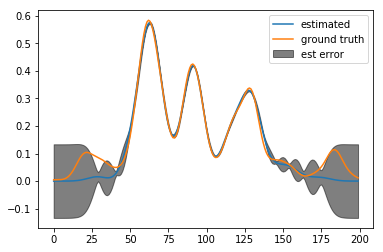

In [8]:
figure()
μ = m.predict_mean0().detach().squeeze().numpy()
σ = m.predict_var0().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(200),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot((data_gen.mean_A()/data_gen.n_A).numpy()/2,label='ground truth')
legend()

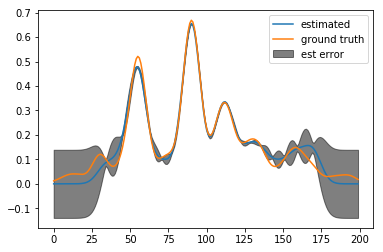

In [9]:
figure()
μ = m.predict_mean1().detach().squeeze().numpy()
σ = m.predict_var1().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(200),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot((data_gen.mean_B()/data_gen.n_B).numpy()/2,label='ground truth')
legend()

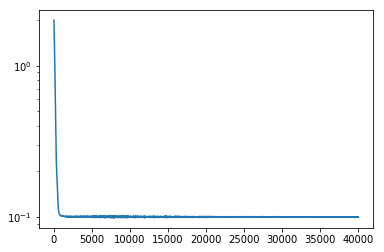

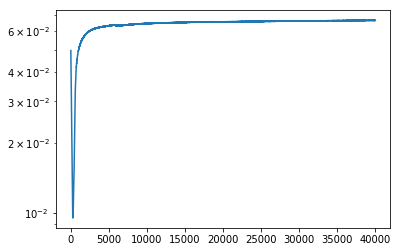

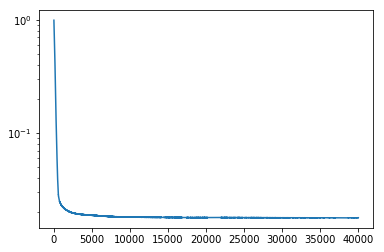

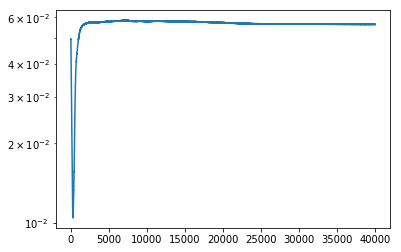

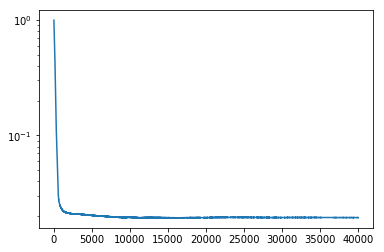

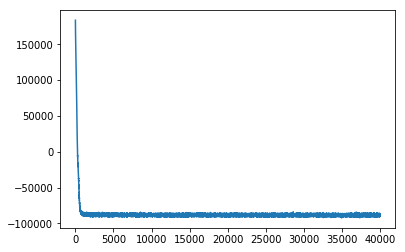

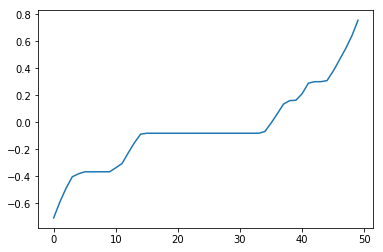

In [10]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
semilogy(Logger.val_dict['stored_K.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K0._amplitude_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K1._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K1._amplitude_storage'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u0'].detach().numpy().squeeze()))

## Example 2

1. Sum of 1 linear signal and 1 quadratic signal from identical SASE source
2. single pixel detector
2. Shared f axis for SASE source among both signals
2. Symmetric mean function for quadratic signal
2. Gaussian likelihood
3. MC for evaluation of variational expectation

In [11]:
class NonlinearAndLinear(torch.nn.Module):
    def __init__(self, UA, UB, F):
        """
        This is a fake data generator for chain GP problem. It's not a physical signal, just one
        where the signal has known hyper parameters. Useful for checking proper convergence of the
        optimization problem.
        """

        super().__init__()
        self.UA = UA
        self.UB = UB
        self.F = F
        m1 = Vector('m1')
        m2 = Vector('m2')
        KA = Kernel('KA')
        KB = Kernel('KB')
        ua = Vector('ua')
        ub = Vector('ub')
        f = Vector('f')
        mf_A = mean_1D(KA, ua, f, m1)
        mf_B = mean_2D(KB, KB, ub, ub, f, f, m2)
        graph = expr2graph(Label(String("mf_B"), mf_B))
        self._mf_B = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("mf_A"), mf_A))
        self._mf_A = graph2ast(graph, compiled=True, debug=False)
        self._makepos = SoftplusTransform()
        self.stored_kernels = torch.nn.ModuleDict({
            'KA': ARDRBFKernel(lengthscale=torch.tensor([[0.05]]),
                                  transforms=[self._makepos, self._makepos]),
            'KB': ARDRBFKernel(lengthscale=torch.tensor([[0.05]]),
                                  transforms=[self._makepos, self._makepos])
        })
        with torch.no_grad():
            filter2d = torch.ger(torch.linspace(-1, 1, UB).div(0.8).pow(2).neg().exp(),
                                 torch.linspace(-1, 1, UB).div(0.8).pow(2).neg().exp())
            m1 = torch.empty(UA, 1).normal_() * torch.linspace(-1, 1, UA).div(0.8).pow(2).neg().exp().reshape(-1, 1)
            m2 = torch.empty(UB * UB, 1).normal_() * filter2d.reshape(-1, 1)
            self.params = torch.nn.ParameterDict({
                'm1': torch.nn.Parameter(m1.pow(2)),
                'm2': torch.nn.Parameter(m2.pow(2)),
                'f': torch.nn.Parameter(torch.linspace(-1, 1, F).unsqueeze(1)),
                'ua': torch.nn.Parameter(torch.linspace(-1, 1, UA).unsqueeze(1)),
                'ub': torch.nn.Parameter(torch.linspace(-1, 1, UB).unsqueeze(1)),
            })

    def mean_B(self):
        leaves = {
            **self.params,
            **self.stored_kernels,
        }
        r = self._mf_B(**leaves).mf_B.reshape(self.F, self.F).detach()
        return 0.5 * r + 0.5 * r.t()

    def mean_A(self):
        leaves = {
            **self.params,
            **self.stored_kernels,
        }
        r = self._mf_A(**leaves)
        return r.mf_A.detach()

    def make_fake_data(self, Nshots):
        S_A = self.mean_A()
        X = torch.from_numpy(make_sase(self.F, Nshots).astype('float32'))
        X = X / X.max()
        #         c0_A = X.sum(dim=1).mean()
        #         W_A = X/c0_A
        W_A = X
        y_A = W_A @ S_A
        n_A = y_A.mean()
        y_A /= n_A
        self.n_A = n_A

        S_B = self.mean_B().reshape(-1, 1)
        y_B = rkr_mv([X, X], S_B)
        n_B = y_B.mean()
        y_B /= n_B
        self.n_B = n_B

        return y_A, y_B, X  # , Xp

In [12]:
data_gen2 = NonlinearAndLinear(50,50,200)

In [13]:
y0, y1, X = data_gen2.make_fake_data(100000)
yc = y0/2 + y1/2 + torch.randn(100000,1)/10

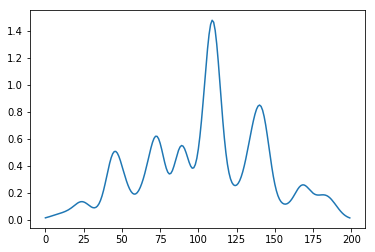

In [14]:
figure()
plot((data_gen2.mean_A()/data_gen2.n_A).numpy())

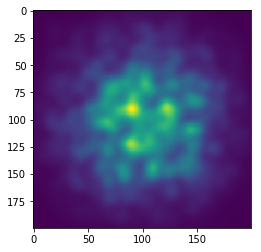

In [15]:
figure()
imshow((data_gen2.mean_B()/data_gen2.n_B).numpy())

In [16]:
class VFE_2D_GPMM_Chained(torch.nn.Module):
    def __init__(self, U0, U1, F, Ntotal, Nmc = 100, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        f = Vector('f')
        m0 = Vector('m0')
        λ0 = Vector('λ0')
        u0 = Vector('u0')
        K0 = Kernel('K0')
        m1 = Vector('m1')
        λ1 = Vector('λ1')
        u1 = Vector('u1')
        K1 = Kernel('K1')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        Nmc = Constant(Nmc)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl_1D(K0, u0, λ0, m0, jitter) + kl_2D(K1, K1, u1, u1, λ1, λ1, m1, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        m0f = weighted_1D_mean(K0, u0, f, m0, X)
        m1f = fully_weighted_2D_mean(K1, K1, u1, u1, f, f, m1, X, X)
        var0f = weighted_var_1D_diag(K0, u0, f, λ0, X, jitter)
        
        t1 = weighted_var_fullspace_diag(K1, f, X) * weighted_var_fullspace_diag(K1, f, X)
        t2 = weighted_var_subspace_diag(K1, u1, f, X, jitter) * weighted_var_subspace_diag(K1, u1, f, X, jitter)
        t3 = weighted_var_posterior_diag(K1, u1, f, λ1, X, jitter) * weighted_var_posterior_diag(K1, u1, f, λ1, X, jitter)
        var1f = t1 - t2 + t3
    
        
        ### Gaussian Likelihood in f-space ###
        ϵ0 = StdNormalSample(m0f,Nmc)
        ϵ1 = StdNormalSample(m1f,Nmc)
        z0 = Sqrt(var0f)*ϵ0 + m0f
        z1 = Sqrt(var1f)*ϵ1 + m1f
        z = z0 + z1
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        m0f = mean_1D(K0, u0, f, m0)
        m1f = mean_2D(K1, K1, u1, u1, f, f, m1)
        graph = expr2graph(Label(String("mean0_pred"), m0f))
        self._mean0_pred = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("mean1_pred"), m1f))
        self._mean1_pred = graph2ast(graph, compiled=True, debug=False)
        var0f = var_1D_diag(K0, u0, f, λ0, jitter)
        t1 = KroneckerProduct(var_fullspace_diag(K1, f), var_fullspace_diag(K1, f))
        t2 = KroneckerProduct(var_subspace_diag(K1, u1, f, jitter), var_subspace_diag(K1, u1, f, jitter))
        t3 = KroneckerProduct(var_posterior_diag(K1, u1, f, λ1, jitter), var_posterior_diag(K1, u1, f, λ1, jitter))
        var1f = t1 - t2 + t3
        graph = expr2graph(Label(String("var0_pred"), var0f))
        self._var0_pred = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("var1_pred"), var1f))
        self._var1_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm0': torch.nn.Parameter(torch.randn((U0,1),dtype=self.dtype)/(U0)),
                'λ0': torch.nn.Parameter(5*torch.ones((U0,1),dtype=self.dtype)),
                'λ1': torch.nn.Parameter(5*torch.ones((U1,1),dtype=self.dtype)),
            })
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                'u1': torch.nn.Parameter(torch.linspace(-1,1,U1,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f': torch.nn.Parameter(torch.linspace(-1,1,F,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_K = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), transforms=[self._makepos, self._makepos]),
                'K1': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), transforms=[self._makepos, self._makepos]),
                })
            self.m1 = Symmetric2DVector(U1)
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'm1': self.m1()
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean0(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._mean0_pred(**leaves)
        return result.mean0_pred
    def predict_var0(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._var0_pred(**leaves)
        return result.var0_pred
    def predict_mean1(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._mean1_pred(**leaves)
        return result.mean1_pred
    def predict_var1(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._var1_pred(**leaves)
        return result.var1_pred

In [17]:
m = VFE_2D_GPMM_Chained(50,50,200,100000,std_lik_init=2.0,lenscale_init=0.05)
m.cuda()
optimizer = torch.optim.Adam(m.parameters(),lr=1e-2)
epochs = 2000
scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(X,yc)
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_K.K0._lengthscale_storage': m._makepos,
                          'stored_K.K0._amplitude_storage': m._makepos,
                          'stored_K.K1._lengthscale_storage': m._makepos,
                          'stored_K.K1._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    d = DataLoader(dataset=data, shuffle=True, batch_size=5000)
    for Xb,yb in d:
        ybc, Xbc = yb.cuda(), Xb.cuda()
        optimizer.zero_grad()
        loss = m.loss(ybc,Xbc)
        loss.backward()
        optimizer.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    scheduler.step()
    print(Logger.report("epoch {:d}: ".format(i)))

epoch 0: hyper_params.std_lik: 1.82731, stored_K.K0._lengthscale_storage: 0.0436994, stored_K.K0._amplitude_storage: 0.908535, stored_K.K1._lengthscale_storage: 0.0466036, stored_K.K1._amplitude_storage: 0.952173, loss: 160652, step_size: 0.01, 
epoch 1: hyper_params.std_lik: 1.65388, stored_K.K0._lengthscale_storage: 0.0383973, stored_K.K0._amplitude_storage: 0.822979, stored_K.K1._lengthscale_storage: 0.0440595, stored_K.K1._amplitude_storage: 0.912775, loss: 150775, step_size: 0.01, 
epoch 2: hyper_params.std_lik: 1.48363, stored_K.K0._lengthscale_storage: 0.0332527, stored_K.K0._amplitude_storage: 0.733567, stored_K.K1._lengthscale_storage: 0.041914, stored_K.K1._amplitude_storage: 0.876776, loss: 141401, step_size: 0.01, 
epoch 3: hyper_params.std_lik: 1.31834, stored_K.K0._lengthscale_storage: 0.0286014, stored_K.K0._amplitude_storage: 0.645621, stored_K.K1._lengthscale_storage: 0.0398288, stored_K.K1._amplitude_storage: 0.839623, loss: 127499, step_size: 0.01, 
epoch 4: hyper_pa

epoch 33: hyper_params.std_lik: 0.108417, stored_K.K0._lengthscale_storage: 0.0167635, stored_K.K0._amplitude_storage: 0.071072, stored_K.K1._lengthscale_storage: 0.0248246, stored_K.K1._amplitude_storage: 0.285922, loss: -81421.5, step_size: 0.01, 
epoch 34: hyper_params.std_lik: 0.107479, stored_K.K0._lengthscale_storage: 0.017253, stored_K.K0._amplitude_storage: 0.0699555, stored_K.K1._lengthscale_storage: 0.0249732, stored_K.K1._amplitude_storage: 0.285144, loss: -77726.6, step_size: 0.01, 
epoch 35: hyper_params.std_lik: 0.109901, stored_K.K0._lengthscale_storage: 0.0178026, stored_K.K0._amplitude_storage: 0.0690245, stored_K.K1._lengthscale_storage: 0.0251439, stored_K.K1._amplitude_storage: 0.282983, loss: -80210.6, step_size: 0.01, 
epoch 36: hyper_params.std_lik: 0.108764, stored_K.K0._lengthscale_storage: 0.0181196, stored_K.K0._amplitude_storage: 0.0673456, stored_K.K1._lengthscale_storage: 0.0252092, stored_K.K1._amplitude_storage: 0.280712, loss: -79921.5, step_size: 0.01,

epoch 66: hyper_params.std_lik: 0.106836, stored_K.K0._lengthscale_storage: 0.0247213, stored_K.K0._amplitude_storage: 0.0545754, stored_K.K1._lengthscale_storage: 0.02809, stored_K.K1._amplitude_storage: 0.258155, loss: -81593.8, step_size: 0.0095, 
epoch 67: hyper_params.std_lik: 0.105415, stored_K.K0._lengthscale_storage: 0.0250017, stored_K.K0._amplitude_storage: 0.0544767, stored_K.K1._lengthscale_storage: 0.028184, stored_K.K1._amplitude_storage: 0.257488, loss: -83881, step_size: 0.0095, 
epoch 68: hyper_params.std_lik: 0.102839, stored_K.K0._lengthscale_storage: 0.0251515, stored_K.K0._amplitude_storage: 0.0542611, stored_K.K1._lengthscale_storage: 0.0282732, stored_K.K1._amplitude_storage: 0.257218, loss: -84618.9, step_size: 0.0095, 
epoch 69: hyper_params.std_lik: 0.102615, stored_K.K0._lengthscale_storage: 0.0252859, stored_K.K0._amplitude_storage: 0.0540362, stored_K.K1._lengthscale_storage: 0.0283358, stored_K.K1._amplitude_storage: 0.256755, loss: -80291.3, step_size: 0.

epoch 99: hyper_params.std_lik: 0.101853, stored_K.K0._lengthscale_storage: 0.0295896, stored_K.K0._amplitude_storage: 0.0493645, stored_K.K1._lengthscale_storage: 0.0303986, stored_K.K1._amplitude_storage: 0.243547, loss: -84025, step_size: 0.0095, 
epoch 100: hyper_params.std_lik: 0.101403, stored_K.K0._lengthscale_storage: 0.0296369, stored_K.K0._amplitude_storage: 0.0491111, stored_K.K1._lengthscale_storage: 0.0304844, stored_K.K1._amplitude_storage: 0.243366, loss: -84751.3, step_size: 0.0095, 
epoch 101: hyper_params.std_lik: 0.10208, stored_K.K0._lengthscale_storage: 0.0296942, stored_K.K0._amplitude_storage: 0.0489362, stored_K.K1._lengthscale_storage: 0.0305446, stored_K.K1._amplitude_storage: 0.243017, loss: -83827.8, step_size: 0.009025, 
epoch 102: hyper_params.std_lik: 0.103042, stored_K.K0._lengthscale_storage: 0.029916, stored_K.K0._amplitude_storage: 0.0490177, stored_K.K1._lengthscale_storage: 0.0306279, stored_K.K1._amplitude_storage: 0.242497, loss: -85874.9, step_si

epoch 132: hyper_params.std_lik: 0.101101, stored_K.K0._lengthscale_storage: 0.0328238, stored_K.K0._amplitude_storage: 0.0459231, stored_K.K1._lengthscale_storage: 0.0326714, stored_K.K1._amplitude_storage: 0.230894, loss: -85281.8, step_size: 0.009025, 
epoch 133: hyper_params.std_lik: 0.10172, stored_K.K0._lengthscale_storage: 0.0328042, stored_K.K0._amplitude_storage: 0.045727, stored_K.K1._lengthscale_storage: 0.0327386, stored_K.K1._amplitude_storage: 0.230658, loss: -87106, step_size: 0.009025, 
epoch 134: hyper_params.std_lik: 0.10101, stored_K.K0._lengthscale_storage: 0.0329349, stored_K.K0._amplitude_storage: 0.0457246, stored_K.K1._lengthscale_storage: 0.032798, stored_K.K1._amplitude_storage: 0.230374, loss: -84107.1, step_size: 0.009025, 
epoch 135: hyper_params.std_lik: 0.101411, stored_K.K0._lengthscale_storage: 0.0330925, stored_K.K0._amplitude_storage: 0.0457717, stored_K.K1._lengthscale_storage: 0.032844, stored_K.K1._amplitude_storage: 0.23005, loss: -86316.5, step_s

epoch 164: hyper_params.std_lik: 0.100802, stored_K.K0._lengthscale_storage: 0.0351919, stored_K.K0._amplitude_storage: 0.0433192, stored_K.K1._lengthscale_storage: 0.0350644, stored_K.K1._amplitude_storage: 0.219665, loss: -84524.5, step_size: 0.00857375, 
epoch 165: hyper_params.std_lik: 0.101069, stored_K.K0._lengthscale_storage: 0.0352665, stored_K.K0._amplitude_storage: 0.0433228, stored_K.K1._lengthscale_storage: 0.0350919, stored_K.K1._amplitude_storage: 0.219399, loss: -85680.2, step_size: 0.00857375, 
epoch 166: hyper_params.std_lik: 0.101153, stored_K.K0._lengthscale_storage: 0.0353, stored_K.K0._amplitude_storage: 0.0432798, stored_K.K1._lengthscale_storage: 0.0351183, stored_K.K1._amplitude_storage: 0.219137, loss: -85763.8, step_size: 0.00857375, 
epoch 167: hyper_params.std_lik: 0.100989, stored_K.K0._lengthscale_storage: 0.0352954, stored_K.K0._amplitude_storage: 0.0431937, stored_K.K1._lengthscale_storage: 0.035192, stored_K.K1._amplitude_storage: 0.219134, loss: -86083

epoch 196: hyper_params.std_lik: 0.101758, stored_K.K0._lengthscale_storage: 0.0369435, stored_K.K0._amplitude_storage: 0.0417124, stored_K.K1._lengthscale_storage: 0.0367592, stored_K.K1._amplitude_storage: 0.210734, loss: -86831.3, step_size: 0.00857375, 
epoch 197: hyper_params.std_lik: 0.101326, stored_K.K0._lengthscale_storage: 0.0370303, stored_K.K0._amplitude_storage: 0.0417179, stored_K.K1._lengthscale_storage: 0.0367528, stored_K.K1._amplitude_storage: 0.210229, loss: -86658.3, step_size: 0.00857375, 
epoch 198: hyper_params.std_lik: 0.102052, stored_K.K0._lengthscale_storage: 0.0372646, stored_K.K0._amplitude_storage: 0.0419106, stored_K.K1._lengthscale_storage: 0.0368283, stored_K.K1._amplitude_storage: 0.210128, loss: -85191.8, step_size: 0.00857375, 
epoch 199: hyper_params.std_lik: 0.101492, stored_K.K0._lengthscale_storage: 0.0372152, stored_K.K0._amplitude_storage: 0.0417474, stored_K.K1._lengthscale_storage: 0.0368571, stored_K.K1._amplitude_storage: 0.209757, loss: -8

epoch 228: hyper_params.std_lik: 0.100646, stored_K.K0._lengthscale_storage: 0.0384695, stored_K.K0._amplitude_storage: 0.0407517, stored_K.K1._lengthscale_storage: 0.0381963, stored_K.K1._amplitude_storage: 0.20315, loss: -85557.7, step_size: 0.00814506, 
epoch 229: hyper_params.std_lik: 0.101045, stored_K.K0._lengthscale_storage: 0.0385208, stored_K.K0._amplitude_storage: 0.0407485, stored_K.K1._lengthscale_storage: 0.0382797, stored_K.K1._amplitude_storage: 0.203159, loss: -82498.5, step_size: 0.00814506, 
epoch 230: hyper_params.std_lik: 0.101013, stored_K.K0._lengthscale_storage: 0.0384998, stored_K.K0._amplitude_storage: 0.0406477, stored_K.K1._lengthscale_storage: 0.038287, stored_K.K1._amplitude_storage: 0.202763, loss: -86710.2, step_size: 0.00814506, 
epoch 231: hyper_params.std_lik: 0.10145, stored_K.K0._lengthscale_storage: 0.0384964, stored_K.K0._amplitude_storage: 0.0405863, stored_K.K1._lengthscale_storage: 0.0383421, stored_K.K1._amplitude_storage: 0.20262, loss: -84678

epoch 260: hyper_params.std_lik: 0.101582, stored_K.K0._lengthscale_storage: 0.0396292, stored_K.K0._amplitude_storage: 0.0399211, stored_K.K1._lengthscale_storage: 0.0395185, stored_K.K1._amplitude_storage: 0.196004, loss: -83695.9, step_size: 0.00773781, 
epoch 261: hyper_params.std_lik: 0.102742, stored_K.K0._lengthscale_storage: 0.0397377, stored_K.K0._amplitude_storage: 0.0399415, stored_K.K1._lengthscale_storage: 0.0395629, stored_K.K1._amplitude_storage: 0.195706, loss: -85746.7, step_size: 0.00773781, 
epoch 262: hyper_params.std_lik: 0.100902, stored_K.K0._lengthscale_storage: 0.0397918, stored_K.K0._amplitude_storage: 0.0399272, stored_K.K1._lengthscale_storage: 0.0396996, stored_K.K1._amplitude_storage: 0.19586, loss: -85393.7, step_size: 0.00773781, 
epoch 263: hyper_params.std_lik: 0.101123, stored_K.K0._lengthscale_storage: 0.0396755, stored_K.K0._amplitude_storage: 0.0397424, stored_K.K1._lengthscale_storage: 0.0397105, stored_K.K1._amplitude_storage: 0.195482, loss: -86

epoch 292: hyper_params.std_lik: 0.100633, stored_K.K0._lengthscale_storage: 0.0412226, stored_K.K0._amplitude_storage: 0.0388777, stored_K.K1._lengthscale_storage: 0.0416161, stored_K.K1._amplitude_storage: 0.188649, loss: -87621.4, step_size: 0.00773781, 
epoch 293: hyper_params.std_lik: 0.101292, stored_K.K0._lengthscale_storage: 0.041266, stored_K.K0._amplitude_storage: 0.0388742, stored_K.K1._lengthscale_storage: 0.0416998, stored_K.K1._amplitude_storage: 0.188682, loss: -85420.2, step_size: 0.00773781, 
epoch 294: hyper_params.std_lik: 0.100814, stored_K.K0._lengthscale_storage: 0.0412695, stored_K.K0._amplitude_storage: 0.0388387, stored_K.K1._lengthscale_storage: 0.0416786, stored_K.K1._amplitude_storage: 0.188279, loss: -85758.4, step_size: 0.00773781, 
epoch 295: hyper_params.std_lik: 0.101533, stored_K.K0._lengthscale_storage: 0.0413609, stored_K.K0._amplitude_storage: 0.0388745, stored_K.K1._lengthscale_storage: 0.0417877, stored_K.K1._amplitude_storage: 0.188403, loss: -86

epoch 324: hyper_params.std_lik: 0.101008, stored_K.K0._lengthscale_storage: 0.0420101, stored_K.K0._amplitude_storage: 0.0382716, stored_K.K1._lengthscale_storage: 0.0428176, stored_K.K1._amplitude_storage: 0.182922, loss: -86549.6, step_size: 0.00735092, 
epoch 325: hyper_params.std_lik: 0.100918, stored_K.K0._lengthscale_storage: 0.0419689, stored_K.K0._amplitude_storage: 0.0381984, stored_K.K1._lengthscale_storage: 0.0429001, stored_K.K1._amplitude_storage: 0.182964, loss: -85813.1, step_size: 0.00735092, 
epoch 326: hyper_params.std_lik: 0.100326, stored_K.K0._lengthscale_storage: 0.0419514, stored_K.K0._amplitude_storage: 0.0381546, stored_K.K1._lengthscale_storage: 0.0429181, stored_K.K1._amplitude_storage: 0.182765, loss: -86517.2, step_size: 0.00735092, 
epoch 327: hyper_params.std_lik: 0.101296, stored_K.K0._lengthscale_storage: 0.0419455, stored_K.K0._amplitude_storage: 0.0381194, stored_K.K1._lengthscale_storage: 0.0429472, stored_K.K1._amplitude_storage: 0.182607, loss: -8

epoch 356: hyper_params.std_lik: 0.100414, stored_K.K0._lengthscale_storage: 0.0426259, stored_K.K0._amplitude_storage: 0.0376369, stored_K.K1._lengthscale_storage: 0.0440434, stored_K.K1._amplitude_storage: 0.17778, loss: -87667.2, step_size: 0.00698337, 
epoch 357: hyper_params.std_lik: 0.100807, stored_K.K0._lengthscale_storage: 0.0426409, stored_K.K0._amplitude_storage: 0.037624, stored_K.K1._lengthscale_storage: 0.0440845, stored_K.K1._amplitude_storage: 0.177671, loss: -86795.5, step_size: 0.00698337, 
epoch 358: hyper_params.std_lik: 0.100928, stored_K.K0._lengthscale_storage: 0.0426649, stored_K.K0._amplitude_storage: 0.0376151, stored_K.K1._lengthscale_storage: 0.044145, stored_K.K1._amplitude_storage: 0.177648, loss: -85799.3, step_size: 0.00698337, 
epoch 359: hyper_params.std_lik: 0.100863, stored_K.K0._lengthscale_storage: 0.0427334, stored_K.K0._amplitude_storage: 0.0376442, stored_K.K1._lengthscale_storage: 0.0441654, stored_K.K1._amplitude_storage: 0.177457, loss: -8625

epoch 388: hyper_params.std_lik: 0.100628, stored_K.K0._lengthscale_storage: 0.0432447, stored_K.K0._amplitude_storage: 0.037182, stored_K.K1._lengthscale_storage: 0.0451632, stored_K.K1._amplitude_storage: 0.173007, loss: -86831.1, step_size: 0.00698337, 
epoch 389: hyper_params.std_lik: 0.101543, stored_K.K0._lengthscale_storage: 0.0432804, stored_K.K0._amplitude_storage: 0.0371901, stored_K.K1._lengthscale_storage: 0.0452209, stored_K.K1._amplitude_storage: 0.172957, loss: -86122.9, step_size: 0.00698337, 
epoch 390: hyper_params.std_lik: 0.100424, stored_K.K0._lengthscale_storage: 0.0432562, stored_K.K0._amplitude_storage: 0.0371419, stored_K.K1._lengthscale_storage: 0.0452916, stored_K.K1._amplitude_storage: 0.172964, loss: -84948.7, step_size: 0.00698337, 
epoch 391: hyper_params.std_lik: 0.101122, stored_K.K0._lengthscale_storage: 0.0432529, stored_K.K0._amplitude_storage: 0.0371179, stored_K.K1._lengthscale_storage: 0.0452827, stored_K.K1._amplitude_storage: 0.172682, loss: -85

epoch 420: hyper_params.std_lik: 0.100737, stored_K.K0._lengthscale_storage: 0.0438831, stored_K.K0._amplitude_storage: 0.0366969, stored_K.K1._lengthscale_storage: 0.0463967, stored_K.K1._amplitude_storage: 0.168449, loss: -87143.7, step_size: 0.0066342, 
epoch 421: hyper_params.std_lik: 0.100562, stored_K.K0._lengthscale_storage: 0.0439234, stored_K.K0._amplitude_storage: 0.0367046, stored_K.K1._lengthscale_storage: 0.046468, stored_K.K1._amplitude_storage: 0.168451, loss: -85835.8, step_size: 0.0066342, 
epoch 422: hyper_params.std_lik: 0.104446, stored_K.K0._lengthscale_storage: 0.0438632, stored_K.K0._amplitude_storage: 0.036635, stored_K.K1._lengthscale_storage: 0.046425, stored_K.K1._amplitude_storage: 0.167987, loss: -84485.2, step_size: 0.0066342, 
epoch 423: hyper_params.std_lik: 0.101522, stored_K.K0._lengthscale_storage: 0.043939, stored_K.K0._amplitude_storage: 0.0366544, stored_K.K1._lengthscale_storage: 0.0465689, stored_K.K1._amplitude_storage: 0.168123, loss: -86319.2,

epoch 452: hyper_params.std_lik: 0.101022, stored_K.K0._lengthscale_storage: 0.0443964, stored_K.K0._amplitude_storage: 0.0363875, stored_K.K1._lengthscale_storage: 0.0474108, stored_K.K1._amplitude_storage: 0.164223, loss: -84625.2, step_size: 0.00630249, 
epoch 453: hyper_params.std_lik: 0.100415, stored_K.K0._lengthscale_storage: 0.0443399, stored_K.K0._amplitude_storage: 0.0363254, stored_K.K1._lengthscale_storage: 0.0474425, stored_K.K1._amplitude_storage: 0.164115, loss: -88602.3, step_size: 0.00630249, 
epoch 454: hyper_params.std_lik: 0.10018, stored_K.K0._lengthscale_storage: 0.044316, stored_K.K0._amplitude_storage: 0.0362862, stored_K.K1._lengthscale_storage: 0.0474486, stored_K.K1._amplitude_storage: 0.163916, loss: -85564.8, step_size: 0.00630249, 
epoch 455: hyper_params.std_lik: 0.101591, stored_K.K0._lengthscale_storage: 0.044388, stored_K.K0._amplitude_storage: 0.0363247, stored_K.K1._lengthscale_storage: 0.0475235, stored_K.K1._amplitude_storage: 0.163937, loss: -8715

epoch 484: hyper_params.std_lik: 0.101435, stored_K.K0._lengthscale_storage: 0.0448972, stored_K.K0._amplitude_storage: 0.0360682, stored_K.K1._lengthscale_storage: 0.0483949, stored_K.K1._amplitude_storage: 0.15992, loss: -86274.8, step_size: 0.00630249, 
epoch 485: hyper_params.std_lik: 0.100258, stored_K.K0._lengthscale_storage: 0.0448189, stored_K.K0._amplitude_storage: 0.0359834, stored_K.K1._lengthscale_storage: 0.048497, stored_K.K1._amplitude_storage: 0.159973, loss: -87307.4, step_size: 0.00630249, 
epoch 486: hyper_params.std_lik: 0.101117, stored_K.K0._lengthscale_storage: 0.0448199, stored_K.K0._amplitude_storage: 0.0359642, stored_K.K1._lengthscale_storage: 0.0485398, stored_K.K1._amplitude_storage: 0.159886, loss: -85132.5, step_size: 0.00630249, 
epoch 487: hyper_params.std_lik: 0.100258, stored_K.K0._lengthscale_storage: 0.0448624, stored_K.K0._amplitude_storage: 0.0359782, stored_K.K1._lengthscale_storage: 0.0486383, stored_K.K1._amplitude_storage: 0.159994, loss: -851

epoch 516: hyper_params.std_lik: 0.101576, stored_K.K0._lengthscale_storage: 0.0453561, stored_K.K0._amplitude_storage: 0.0357837, stored_K.K1._lengthscale_storage: 0.0495635, stored_K.K1._amplitude_storage: 0.15636, loss: -84444.3, step_size: 0.00598737, 
epoch 517: hyper_params.std_lik: 0.100455, stored_K.K0._lengthscale_storage: 0.0452756, stored_K.K0._amplitude_storage: 0.035706, stored_K.K1._lengthscale_storage: 0.0495856, stored_K.K1._amplitude_storage: 0.156219, loss: -85024.6, step_size: 0.00598737, 
epoch 518: hyper_params.std_lik: 0.099947, stored_K.K0._lengthscale_storage: 0.0452959, stored_K.K0._amplitude_storage: 0.0356996, stored_K.K1._lengthscale_storage: 0.0496152, stored_K.K1._amplitude_storage: 0.156103, loss: -86919.7, step_size: 0.00598737, 
epoch 519: hyper_params.std_lik: 0.100951, stored_K.K0._lengthscale_storage: 0.0453272, stored_K.K0._amplitude_storage: 0.0357035, stored_K.K1._lengthscale_storage: 0.0496645, stored_K.K1._amplitude_storage: 0.156046, loss: -876

epoch 548: hyper_params.std_lik: 0.101883, stored_K.K0._lengthscale_storage: 0.0456946, stored_K.K0._amplitude_storage: 0.0354368, stored_K.K1._lengthscale_storage: 0.0505784, stored_K.K1._amplitude_storage: 0.152481, loss: -85254.5, step_size: 0.00598737, 
epoch 549: hyper_params.std_lik: 0.100771, stored_K.K0._lengthscale_storage: 0.0457328, stored_K.K0._amplitude_storage: 0.0354428, stored_K.K1._lengthscale_storage: 0.0506479, stored_K.K1._amplitude_storage: 0.152488, loss: -85085.9, step_size: 0.00598737, 
epoch 550: hyper_params.std_lik: 0.100524, stored_K.K0._lengthscale_storage: 0.045815, stored_K.K0._amplitude_storage: 0.0354916, stored_K.K1._lengthscale_storage: 0.0507317, stored_K.K1._amplitude_storage: 0.15251, loss: -87623.6, step_size: 0.00598737, 
epoch 551: hyper_params.std_lik: 0.100753, stored_K.K0._lengthscale_storage: 0.0458072, stored_K.K0._amplitude_storage: 0.0354766, stored_K.K1._lengthscale_storage: 0.0506997, stored_K.K1._amplitude_storage: 0.152239, loss: -862

epoch 581: hyper_params.std_lik: 0.100004, stored_K.K0._lengthscale_storage: 0.0460318, stored_K.K0._amplitude_storage: 0.0352467, stored_K.K1._lengthscale_storage: 0.0516478, stored_K.K1._amplitude_storage: 0.149392, loss: -85958.7, step_size: 0.005688, 
epoch 582: hyper_params.std_lik: 0.100735, stored_K.K0._lengthscale_storage: 0.0460778, stored_K.K0._amplitude_storage: 0.0352632, stored_K.K1._lengthscale_storage: 0.0516746, stored_K.K1._amplitude_storage: 0.14928, loss: -87268.9, step_size: 0.005688, 
epoch 583: hyper_params.std_lik: 0.100786, stored_K.K0._lengthscale_storage: 0.0460556, stored_K.K0._amplitude_storage: 0.0352265, stored_K.K1._lengthscale_storage: 0.0517035, stored_K.K1._amplitude_storage: 0.14917, loss: -86920.5, step_size: 0.005688, 
epoch 584: hyper_params.std_lik: 0.0997123, stored_K.K0._lengthscale_storage: 0.0460376, stored_K.K0._amplitude_storage: 0.0352095, stored_K.K1._lengthscale_storage: 0.0517306, stored_K.K1._amplitude_storage: 0.149052, loss: -88008.1,

epoch 614: hyper_params.std_lik: 0.10113, stored_K.K0._lengthscale_storage: 0.0464294, stored_K.K0._amplitude_storage: 0.0350471, stored_K.K1._lengthscale_storage: 0.0526713, stored_K.K1._amplitude_storage: 0.145881, loss: -86663.5, step_size: 0.0054036, 
epoch 615: hyper_params.std_lik: 0.100858, stored_K.K0._lengthscale_storage: 0.0464555, stored_K.K0._amplitude_storage: 0.0350507, stored_K.K1._lengthscale_storage: 0.0527809, stored_K.K1._amplitude_storage: 0.145989, loss: -85003.9, step_size: 0.0054036, 
epoch 616: hyper_params.std_lik: 0.101928, stored_K.K0._lengthscale_storage: 0.0464716, stored_K.K0._amplitude_storage: 0.035056, stored_K.K1._lengthscale_storage: 0.052811, stored_K.K1._amplitude_storage: 0.145893, loss: -86798.5, step_size: 0.0054036, 
epoch 617: hyper_params.std_lik: 0.0996506, stored_K.K0._lengthscale_storage: 0.0463971, stored_K.K0._amplitude_storage: 0.0349885, stored_K.K1._lengthscale_storage: 0.0527913, stored_K.K1._amplitude_storage: 0.145632, loss: -87329.

epoch 646: hyper_params.std_lik: 0.101055, stored_K.K0._lengthscale_storage: 0.0466071, stored_K.K0._amplitude_storage: 0.0348125, stored_K.K1._lengthscale_storage: 0.053557, stored_K.K1._amplitude_storage: 0.143049, loss: -84917.1, step_size: 0.0054036, 
epoch 647: hyper_params.std_lik: 0.100757, stored_K.K0._lengthscale_storage: 0.0466517, stored_K.K0._amplitude_storage: 0.034837, stored_K.K1._lengthscale_storage: 0.0536005, stored_K.K1._amplitude_storage: 0.143002, loss: -86790.1, step_size: 0.0054036, 
epoch 648: hyper_params.std_lik: 0.100893, stored_K.K0._lengthscale_storage: 0.0467, stored_K.K0._amplitude_storage: 0.0348612, stored_K.K1._lengthscale_storage: 0.053639, stored_K.K1._amplitude_storage: 0.142931, loss: -88952.3, step_size: 0.0054036, 
epoch 649: hyper_params.std_lik: 0.100224, stored_K.K0._lengthscale_storage: 0.0466802, stored_K.K0._amplitude_storage: 0.0348357, stored_K.K1._lengthscale_storage: 0.053624, stored_K.K1._amplitude_storage: 0.142744, loss: -88908.6, st

epoch 678: hyper_params.std_lik: 0.101063, stored_K.K0._lengthscale_storage: 0.0469895, stored_K.K0._amplitude_storage: 0.0346991, stored_K.K1._lengthscale_storage: 0.0544189, stored_K.K1._amplitude_storage: 0.14033, loss: -86789.7, step_size: 0.00513342, 
epoch 679: hyper_params.std_lik: 0.100769, stored_K.K0._lengthscale_storage: 0.0470255, stored_K.K0._amplitude_storage: 0.0347146, stored_K.K1._lengthscale_storage: 0.0544762, stored_K.K1._amplitude_storage: 0.140335, loss: -85420.4, step_size: 0.00513342, 
epoch 680: hyper_params.std_lik: 0.101215, stored_K.K0._lengthscale_storage: 0.0470225, stored_K.K0._amplitude_storage: 0.0346981, stored_K.K1._lengthscale_storage: 0.054506, stored_K.K1._amplitude_storage: 0.140259, loss: -86285.6, step_size: 0.00513342, 
epoch 681: hyper_params.std_lik: 0.0995543, stored_K.K0._lengthscale_storage: 0.0469562, stored_K.K0._amplitude_storage: 0.0346338, stored_K.K1._lengthscale_storage: 0.0545069, stored_K.K1._amplitude_storage: 0.140117, loss: -86

epoch 710: hyper_params.std_lik: 0.100483, stored_K.K0._lengthscale_storage: 0.0472885, stored_K.K0._amplitude_storage: 0.0345456, stored_K.K1._lengthscale_storage: 0.0553439, stored_K.K1._amplitude_storage: 0.137776, loss: -86037.3, step_size: 0.00487675, 
epoch 711: hyper_params.std_lik: 0.10019, stored_K.K0._lengthscale_storage: 0.0472445, stored_K.K0._amplitude_storage: 0.034506, stored_K.K1._lengthscale_storage: 0.05531, stored_K.K1._amplitude_storage: 0.137561, loss: -86529.8, step_size: 0.00487675, 
epoch 712: hyper_params.std_lik: 0.100889, stored_K.K0._lengthscale_storage: 0.0472298, stored_K.K0._amplitude_storage: 0.0344827, stored_K.K1._lengthscale_storage: 0.0554082, stored_K.K1._amplitude_storage: 0.137666, loss: -87133.9, step_size: 0.00487675, 
epoch 713: hyper_params.std_lik: 0.100161, stored_K.K0._lengthscale_storage: 0.0472696, stored_K.K0._amplitude_storage: 0.0345035, stored_K.K1._lengthscale_storage: 0.0554311, stored_K.K1._amplitude_storage: 0.137587, loss: -84587

epoch 742: hyper_params.std_lik: 0.10048, stored_K.K0._lengthscale_storage: 0.0475391, stored_K.K0._amplitude_storage: 0.0343818, stored_K.K1._lengthscale_storage: 0.0562128, stored_K.K1._amplitude_storage: 0.135325, loss: -86254.6, step_size: 0.00487675, 
epoch 743: hyper_params.std_lik: 0.100592, stored_K.K0._lengthscale_storage: 0.0475292, stored_K.K0._amplitude_storage: 0.0343629, stored_K.K1._lengthscale_storage: 0.056213, stored_K.K1._amplitude_storage: 0.135196, loss: -87555, step_size: 0.00487675, 
epoch 744: hyper_params.std_lik: 0.100598, stored_K.K0._lengthscale_storage: 0.0475194, stored_K.K0._amplitude_storage: 0.0343494, stored_K.K1._lengthscale_storage: 0.0562422, stored_K.K1._amplitude_storage: 0.135124, loss: -85049.6, step_size: 0.00487675, 
epoch 745: hyper_params.std_lik: 0.100672, stored_K.K0._lengthscale_storage: 0.0476215, stored_K.K0._amplitude_storage: 0.0343964, stored_K.K1._lengthscale_storage: 0.0563135, stored_K.K1._amplitude_storage: 0.135133, loss: -85450

epoch 774: hyper_params.std_lik: 0.1003, stored_K.K0._lengthscale_storage: 0.0477467, stored_K.K0._amplitude_storage: 0.0342166, stored_K.K1._lengthscale_storage: 0.0570068, stored_K.K1._amplitude_storage: 0.132844, loss: -85103.6, step_size: 0.00463291, 
epoch 775: hyper_params.std_lik: 0.100732, stored_K.K0._lengthscale_storage: 0.0478192, stored_K.K0._amplitude_storage: 0.0342588, stored_K.K1._lengthscale_storage: 0.0570476, stored_K.K1._amplitude_storage: 0.132811, loss: -87149.7, step_size: 0.00463291, 
epoch 776: hyper_params.std_lik: 0.100683, stored_K.K0._lengthscale_storage: 0.0478744, stored_K.K0._amplitude_storage: 0.0342888, stored_K.K1._lengthscale_storage: 0.0570723, stored_K.K1._amplitude_storage: 0.132744, loss: -86193.7, step_size: 0.00463291, 
epoch 777: hyper_params.std_lik: 0.101141, stored_K.K0._lengthscale_storage: 0.047759, stored_K.K0._amplitude_storage: 0.0341937, stored_K.K1._lengthscale_storage: 0.0570844, stored_K.K1._amplitude_storage: 0.132658, loss: -8647

epoch 806: hyper_params.std_lik: 0.100742, stored_K.K0._lengthscale_storage: 0.0480417, stored_K.K0._amplitude_storage: 0.0341388, stored_K.K1._lengthscale_storage: 0.0578255, stored_K.K1._amplitude_storage: 0.130689, loss: -85755.5, step_size: 0.00440127, 
epoch 807: hyper_params.std_lik: 0.100278, stored_K.K0._lengthscale_storage: 0.0480463, stored_K.K0._amplitude_storage: 0.0341368, stored_K.K1._lengthscale_storage: 0.0578488, stored_K.K1._amplitude_storage: 0.130634, loss: -88428.8, step_size: 0.00440127, 
epoch 808: hyper_params.std_lik: 0.100911, stored_K.K0._lengthscale_storage: 0.0480102, stored_K.K0._amplitude_storage: 0.034111, stored_K.K1._lengthscale_storage: 0.057842, stored_K.K1._amplitude_storage: 0.130502, loss: -86922.6, step_size: 0.00440127, 
epoch 809: hyper_params.std_lik: 0.100295, stored_K.K0._lengthscale_storage: 0.0480382, stored_K.K0._amplitude_storage: 0.0341125, stored_K.K1._lengthscale_storage: 0.0578818, stored_K.K1._amplitude_storage: 0.130472, loss: -881

epoch 838: hyper_params.std_lik: 0.101045, stored_K.K0._lengthscale_storage: 0.0482901, stored_K.K0._amplitude_storage: 0.0340861, stored_K.K1._lengthscale_storage: 0.0586007, stored_K.K1._amplitude_storage: 0.128606, loss: -86482.3, step_size: 0.00440127, 
epoch 839: hyper_params.std_lik: 0.101207, stored_K.K0._lengthscale_storage: 0.04826, stored_K.K0._amplitude_storage: 0.0340415, stored_K.K1._lengthscale_storage: 0.0585752, stored_K.K1._amplitude_storage: 0.12842, loss: -87826.4, step_size: 0.00440127, 
epoch 840: hyper_params.std_lik: 0.100514, stored_K.K0._lengthscale_storage: 0.0482673, stored_K.K0._amplitude_storage: 0.0340373, stored_K.K1._lengthscale_storage: 0.0586331, stored_K.K1._amplitude_storage: 0.128406, loss: -85934.4, step_size: 0.00440127, 
epoch 841: hyper_params.std_lik: 0.100164, stored_K.K0._lengthscale_storage: 0.0483097, stored_K.K0._amplitude_storage: 0.0340577, stored_K.K1._lengthscale_storage: 0.0586251, stored_K.K1._amplitude_storage: 0.128262, loss: -8676

epoch 870: hyper_params.std_lik: 0.100722, stored_K.K0._lengthscale_storage: 0.0483755, stored_K.K0._amplitude_storage: 0.033965, stored_K.K1._lengthscale_storage: 0.0593131, stored_K.K1._amplitude_storage: 0.126553, loss: -88228.7, step_size: 0.0041812, 
epoch 871: hyper_params.std_lik: 0.100547, stored_K.K0._lengthscale_storage: 0.0483732, stored_K.K0._amplitude_storage: 0.0339664, stored_K.K1._lengthscale_storage: 0.0593138, stored_K.K1._amplitude_storage: 0.126462, loss: -87844.6, step_size: 0.0041812, 
epoch 872: hyper_params.std_lik: 0.100491, stored_K.K0._lengthscale_storage: 0.0485254, stored_K.K0._amplitude_storage: 0.0340523, stored_K.K1._lengthscale_storage: 0.0592979, stored_K.K1._amplitude_storage: 0.126313, loss: -86644.4, step_size: 0.0041812, 
epoch 873: hyper_params.std_lik: 0.101116, stored_K.K0._lengthscale_storage: 0.0485018, stored_K.K0._amplitude_storage: 0.0340394, stored_K.K1._lengthscale_storage: 0.0593605, stored_K.K1._amplitude_storage: 0.126342, loss: -85524

epoch 902: hyper_params.std_lik: 0.101115, stored_K.K0._lengthscale_storage: 0.0485068, stored_K.K0._amplitude_storage: 0.0339124, stored_K.K1._lengthscale_storage: 0.0600047, stored_K.K1._amplitude_storage: 0.124685, loss: -86903.6, step_size: 0.00397214, 
epoch 903: hyper_params.std_lik: 0.100727, stored_K.K0._lengthscale_storage: 0.0485331, stored_K.K0._amplitude_storage: 0.0339249, stored_K.K1._lengthscale_storage: 0.0600227, stored_K.K1._amplitude_storage: 0.124627, loss: -86290.4, step_size: 0.00397214, 
epoch 904: hyper_params.std_lik: 0.100252, stored_K.K0._lengthscale_storage: 0.0485139, stored_K.K0._amplitude_storage: 0.0339084, stored_K.K1._lengthscale_storage: 0.0600184, stored_K.K1._amplitude_storage: 0.124529, loss: -83209.7, step_size: 0.00397214, 
epoch 905: hyper_params.std_lik: 0.100799, stored_K.K0._lengthscale_storage: 0.0485532, stored_K.K0._amplitude_storage: 0.033928, stored_K.K1._lengthscale_storage: 0.0600839, stored_K.K1._amplitude_storage: 0.124551, loss: -87

epoch 934: hyper_params.std_lik: 0.100625, stored_K.K0._lengthscale_storage: 0.048687, stored_K.K0._amplitude_storage: 0.0338931, stored_K.K1._lengthscale_storage: 0.0607456, stored_K.K1._amplitude_storage: 0.122869, loss: -86569.6, step_size: 0.00397214, 
epoch 935: hyper_params.std_lik: 0.100697, stored_K.K0._lengthscale_storage: 0.0487054, stored_K.K0._amplitude_storage: 0.033905, stored_K.K1._lengthscale_storage: 0.0607485, stored_K.K1._amplitude_storage: 0.122772, loss: -87274.9, step_size: 0.00397214, 
epoch 936: hyper_params.std_lik: 0.100899, stored_K.K0._lengthscale_storage: 0.0486804, stored_K.K0._amplitude_storage: 0.0338813, stored_K.K1._lengthscale_storage: 0.0608255, stored_K.K1._amplitude_storage: 0.122823, loss: -87241.3, step_size: 0.00397214, 
epoch 937: hyper_params.std_lik: 0.10088, stored_K.K0._lengthscale_storage: 0.0485801, stored_K.K0._amplitude_storage: 0.0338015, stored_K.K1._lengthscale_storage: 0.0608243, stored_K.K1._amplitude_storage: 0.122722, loss: -8785

epoch 966: hyper_params.std_lik: 0.100517, stored_K.K0._lengthscale_storage: 0.0487159, stored_K.K0._amplitude_storage: 0.0337569, stored_K.K1._lengthscale_storage: 0.0615271, stored_K.K1._amplitude_storage: 0.121171, loss: -86790.1, step_size: 0.00377354, 
epoch 967: hyper_params.std_lik: 0.100609, stored_K.K0._lengthscale_storage: 0.0487848, stored_K.K0._amplitude_storage: 0.0337868, stored_K.K1._lengthscale_storage: 0.0614617, stored_K.K1._amplitude_storage: 0.120943, loss: -87008.5, step_size: 0.00377354, 
epoch 968: hyper_params.std_lik: 0.100201, stored_K.K0._lengthscale_storage: 0.0488113, stored_K.K0._amplitude_storage: 0.0337975, stored_K.K1._lengthscale_storage: 0.0615241, stored_K.K1._amplitude_storage: 0.120971, loss: -88439, step_size: 0.00377354, 
epoch 969: hyper_params.std_lik: 0.100951, stored_K.K0._lengthscale_storage: 0.0488882, stored_K.K0._amplitude_storage: 0.0338444, stored_K.K1._lengthscale_storage: 0.0615311, stored_K.K1._amplitude_storage: 0.120886, loss: -860

epoch 998: hyper_params.std_lik: 0.100258, stored_K.K0._lengthscale_storage: 0.0489745, stored_K.K0._amplitude_storage: 0.0337865, stored_K.K1._lengthscale_storage: 0.062175, stored_K.K1._amplitude_storage: 0.119444, loss: -86928.8, step_size: 0.00377354, 
epoch 999: hyper_params.std_lik: 0.10026, stored_K.K0._lengthscale_storage: 0.048965, stored_K.K0._amplitude_storage: 0.0337825, stored_K.K1._lengthscale_storage: 0.0621953, stored_K.K1._amplitude_storage: 0.119393, loss: -85824.4, step_size: 0.00377354, 
epoch 1000: hyper_params.std_lik: 0.100685, stored_K.K0._lengthscale_storage: 0.0489341, stored_K.K0._amplitude_storage: 0.0337617, stored_K.K1._lengthscale_storage: 0.0621945, stored_K.K1._amplitude_storage: 0.119306, loss: -85953.4, step_size: 0.00377354, 
epoch 1001: hyper_params.std_lik: 0.100648, stored_K.K0._lengthscale_storage: 0.0489285, stored_K.K0._amplitude_storage: 0.03376, stored_K.K1._lengthscale_storage: 0.0622285, stored_K.K1._amplitude_storage: 0.119295, loss: -8758

epoch 1030: hyper_params.std_lik: 0.100559, stored_K.K0._lengthscale_storage: 0.0490135, stored_K.K0._amplitude_storage: 0.0337242, stored_K.K1._lengthscale_storage: 0.0628225, stored_K.K1._amplitude_storage: 0.117969, loss: -87503.6, step_size: 0.00358486, 
epoch 1031: hyper_params.std_lik: 0.100383, stored_K.K0._lengthscale_storage: 0.0490052, stored_K.K0._amplitude_storage: 0.033718, stored_K.K1._lengthscale_storage: 0.0628536, stored_K.K1._amplitude_storage: 0.11795, loss: -87910.4, step_size: 0.00358486, 
epoch 1032: hyper_params.std_lik: 0.100709, stored_K.K0._lengthscale_storage: 0.048983, stored_K.K0._amplitude_storage: 0.0337068, stored_K.K1._lengthscale_storage: 0.0628559, stored_K.K1._amplitude_storage: 0.117873, loss: -87844.3, step_size: 0.00358486, 
epoch 1033: hyper_params.std_lik: 0.10055, stored_K.K0._lengthscale_storage: 0.0489699, stored_K.K0._amplitude_storage: 0.0336868, stored_K.K1._lengthscale_storage: 0.0628393, stored_K.K1._amplitude_storage: 0.117758, loss: -8

epoch 1062: hyper_params.std_lik: 0.101363, stored_K.K0._lengthscale_storage: 0.0491367, stored_K.K0._amplitude_storage: 0.0337464, stored_K.K1._lengthscale_storage: 0.0633476, stored_K.K1._amplitude_storage: 0.116394, loss: -88646.2, step_size: 0.00340562, 
epoch 1063: hyper_params.std_lik: 0.100606, stored_K.K0._lengthscale_storage: 0.0490046, stored_K.K0._amplitude_storage: 0.0336456, stored_K.K1._lengthscale_storage: 0.0633906, stored_K.K1._amplitude_storage: 0.116389, loss: -87919.9, step_size: 0.00340562, 
epoch 1064: hyper_params.std_lik: 0.100659, stored_K.K0._lengthscale_storage: 0.049028, stored_K.K0._amplitude_storage: 0.0336612, stored_K.K1._lengthscale_storage: 0.0634457, stored_K.K1._amplitude_storage: 0.11641, loss: -85872.8, step_size: 0.00340562, 
epoch 1065: hyper_params.std_lik: 0.100452, stored_K.K0._lengthscale_storage: 0.0491434, stored_K.K0._amplitude_storage: 0.0337445, stored_K.K1._lengthscale_storage: 0.063458, stored_K.K1._amplitude_storage: 0.116346, loss: -

epoch 1094: hyper_params.std_lik: 0.100383, stored_K.K0._lengthscale_storage: 0.0490274, stored_K.K0._amplitude_storage: 0.0336518, stored_K.K1._lengthscale_storage: 0.064005, stored_K.K1._amplitude_storage: 0.115245, loss: -88646.8, step_size: 0.00340562, 
epoch 1095: hyper_params.std_lik: 0.100487, stored_K.K0._lengthscale_storage: 0.0490948, stored_K.K0._amplitude_storage: 0.0336956, stored_K.K1._lengthscale_storage: 0.0640422, stored_K.K1._amplitude_storage: 0.115242, loss: -86070.5, step_size: 0.00340562, 
epoch 1096: hyper_params.std_lik: 0.100344, stored_K.K0._lengthscale_storage: 0.0490971, stored_K.K0._amplitude_storage: 0.0336946, stored_K.K1._lengthscale_storage: 0.0640092, stored_K.K1._amplitude_storage: 0.115102, loss: -86429.2, step_size: 0.00340562, 
epoch 1097: hyper_params.std_lik: 0.100496, stored_K.K0._lengthscale_storage: 0.0491326, stored_K.K0._amplitude_storage: 0.0337173, stored_K.K1._lengthscale_storage: 0.0640485, stored_K.K1._amplitude_storage: 0.115099, loss:

epoch 1126: hyper_params.std_lik: 0.100572, stored_K.K0._lengthscale_storage: 0.0491743, stored_K.K0._amplitude_storage: 0.0337321, stored_K.K1._lengthscale_storage: 0.0644945, stored_K.K1._amplitude_storage: 0.113939, loss: -85800.5, step_size: 0.00323534, 
epoch 1127: hyper_params.std_lik: 0.100774, stored_K.K0._lengthscale_storage: 0.0491281, stored_K.K0._amplitude_storage: 0.0336965, stored_K.K1._lengthscale_storage: 0.0645067, stored_K.K1._amplitude_storage: 0.113889, loss: -88919.4, step_size: 0.00323534, 
epoch 1128: hyper_params.std_lik: 0.100708, stored_K.K0._lengthscale_storage: 0.0491005, stored_K.K0._amplitude_storage: 0.0336763, stored_K.K1._lengthscale_storage: 0.0645244, stored_K.K1._amplitude_storage: 0.113861, loss: -89172.6, step_size: 0.00323534, 
epoch 1129: hyper_params.std_lik: 0.100347, stored_K.K0._lengthscale_storage: 0.049092, stored_K.K0._amplitude_storage: 0.0336667, stored_K.K1._lengthscale_storage: 0.0645675, stored_K.K1._amplitude_storage: 0.11386, loss: 

epoch 1158: hyper_params.std_lik: 0.100728, stored_K.K0._lengthscale_storage: 0.0491493, stored_K.K0._amplitude_storage: 0.0336967, stored_K.K1._lengthscale_storage: 0.0650763, stored_K.K1._amplitude_storage: 0.112749, loss: -87219.3, step_size: 0.00307357, 
epoch 1159: hyper_params.std_lik: 0.100597, stored_K.K0._lengthscale_storage: 0.0491076, stored_K.K0._amplitude_storage: 0.0336679, stored_K.K1._lengthscale_storage: 0.0650621, stored_K.K1._amplitude_storage: 0.112664, loss: -86988.7, step_size: 0.00307357, 
epoch 1160: hyper_params.std_lik: 0.100771, stored_K.K0._lengthscale_storage: 0.049131, stored_K.K0._amplitude_storage: 0.0336812, stored_K.K1._lengthscale_storage: 0.0650818, stored_K.K1._amplitude_storage: 0.112633, loss: -87169, step_size: 0.00307357, 
epoch 1161: hyper_params.std_lik: 0.100871, stored_K.K0._lengthscale_storage: 0.0491758, stored_K.K0._amplitude_storage: 0.0337159, stored_K.K1._lengthscale_storage: 0.0651234, stored_K.K1._amplitude_storage: 0.112641, loss: -

epoch 1190: hyper_params.std_lik: 0.100279, stored_K.K0._lengthscale_storage: 0.0491921, stored_K.K0._amplitude_storage: 0.0337108, stored_K.K1._lengthscale_storage: 0.0655806, stored_K.K1._amplitude_storage: 0.111559, loss: -86286.1, step_size: 0.00307357, 
epoch 1191: hyper_params.std_lik: 0.100784, stored_K.K0._lengthscale_storage: 0.0492153, stored_K.K0._amplitude_storage: 0.033717, stored_K.K1._lengthscale_storage: 0.0655993, stored_K.K1._amplitude_storage: 0.111522, loss: -86988.1, step_size: 0.00307357, 
epoch 1192: hyper_params.std_lik: 0.100789, stored_K.K0._lengthscale_storage: 0.0492377, stored_K.K0._amplitude_storage: 0.0337361, stored_K.K1._lengthscale_storage: 0.0656473, stored_K.K1._amplitude_storage: 0.11153, loss: -86449.1, step_size: 0.00307357, 
epoch 1193: hyper_params.std_lik: 0.100356, stored_K.K0._lengthscale_storage: 0.0492221, stored_K.K0._amplitude_storage: 0.0337227, stored_K.K1._lengthscale_storage: 0.0656392, stored_K.K1._amplitude_storage: 0.111447, loss: 

epoch 1222: hyper_params.std_lik: 0.100339, stored_K.K0._lengthscale_storage: 0.0492974, stored_K.K0._amplitude_storage: 0.0337692, stored_K.K1._lengthscale_storage: 0.0660992, stored_K.K1._amplitude_storage: 0.110361, loss: -87031.1, step_size: 0.00291989, 
epoch 1223: hyper_params.std_lik: 0.100726, stored_K.K0._lengthscale_storage: 0.049253, stored_K.K0._amplitude_storage: 0.0337338, stored_K.K1._lengthscale_storage: 0.0661441, stored_K.K1._amplitude_storage: 0.110377, loss: -86577.3, step_size: 0.00291989, 
epoch 1224: hyper_params.std_lik: 0.100276, stored_K.K0._lengthscale_storage: 0.0492693, stored_K.K0._amplitude_storage: 0.0337463, stored_K.K1._lengthscale_storage: 0.0661301, stored_K.K1._amplitude_storage: 0.110299, loss: -86236.7, step_size: 0.00291989, 
epoch 1225: hyper_params.std_lik: 0.100602, stored_K.K0._lengthscale_storage: 0.0492469, stored_K.K0._amplitude_storage: 0.0337254, stored_K.K1._lengthscale_storage: 0.0661585, stored_K.K1._amplitude_storage: 0.110281, loss:

epoch 1254: hyper_params.std_lik: 0.100277, stored_K.K0._lengthscale_storage: 0.0493195, stored_K.K0._amplitude_storage: 0.0337588, stored_K.K1._lengthscale_storage: 0.0666383, stored_K.K1._amplitude_storage: 0.109321, loss: -87500.1, step_size: 0.0027739, 
epoch 1255: hyper_params.std_lik: 0.100383, stored_K.K0._lengthscale_storage: 0.0493171, stored_K.K0._amplitude_storage: 0.0337551, stored_K.K1._lengthscale_storage: 0.0666838, stored_K.K1._amplitude_storage: 0.109336, loss: -86548.3, step_size: 0.0027739, 
epoch 1256: hyper_params.std_lik: 0.10075, stored_K.K0._lengthscale_storage: 0.0492696, stored_K.K0._amplitude_storage: 0.0337248, stored_K.K1._lengthscale_storage: 0.0666415, stored_K.K1._amplitude_storage: 0.109202, loss: -89262.9, step_size: 0.0027739, 
epoch 1257: hyper_params.std_lik: 0.100708, stored_K.K0._lengthscale_storage: 0.0493493, stored_K.K0._amplitude_storage: 0.0337752, stored_K.K1._lengthscale_storage: 0.0666883, stored_K.K1._amplitude_storage: 0.109225, loss: -8

epoch 1286: hyper_params.std_lik: 0.100906, stored_K.K0._lengthscale_storage: 0.0493828, stored_K.K0._amplitude_storage: 0.0337887, stored_K.K1._lengthscale_storage: 0.0671078, stored_K.K1._amplitude_storage: 0.108291, loss: -84729, step_size: 0.0027739, 
epoch 1287: hyper_params.std_lik: 0.1008, stored_K.K0._lengthscale_storage: 0.0493621, stored_K.K0._amplitude_storage: 0.0337686, stored_K.K1._lengthscale_storage: 0.0671253, stored_K.K1._amplitude_storage: 0.10825, loss: -86649.4, step_size: 0.0027739, 
epoch 1288: hyper_params.std_lik: 0.100681, stored_K.K0._lengthscale_storage: 0.0493496, stored_K.K0._amplitude_storage: 0.0337655, stored_K.K1._lengthscale_storage: 0.0671554, stored_K.K1._amplitude_storage: 0.108251, loss: -87370.3, step_size: 0.0027739, 
epoch 1289: hyper_params.std_lik: 0.100591, stored_K.K0._lengthscale_storage: 0.0493912, stored_K.K0._amplitude_storage: 0.0337945, stored_K.K1._lengthscale_storage: 0.0671621, stored_K.K1._amplitude_storage: 0.108206, loss: -87307

epoch 1318: hyper_params.std_lik: 0.100595, stored_K.K0._lengthscale_storage: 0.0493689, stored_K.K0._amplitude_storage: 0.0337802, stored_K.K1._lengthscale_storage: 0.0675457, stored_K.K1._amplitude_storage: 0.107325, loss: -87592.6, step_size: 0.0026352, 
epoch 1319: hyper_params.std_lik: 0.100705, stored_K.K0._lengthscale_storage: 0.0493543, stored_K.K0._amplitude_storage: 0.0337699, stored_K.K1._lengthscale_storage: 0.0675668, stored_K.K1._amplitude_storage: 0.107307, loss: -87585.7, step_size: 0.0026352, 
epoch 1320: hyper_params.std_lik: 0.100387, stored_K.K0._lengthscale_storage: 0.0493805, stored_K.K0._amplitude_storage: 0.03378, stored_K.K1._lengthscale_storage: 0.0675707, stored_K.K1._amplitude_storage: 0.107263, loss: -86243.5, step_size: 0.0026352, 
epoch 1321: hyper_params.std_lik: 0.100694, stored_K.K0._lengthscale_storage: 0.0493987, stored_K.K0._amplitude_storage: 0.033799, stored_K.K1._lengthscale_storage: 0.0675735, stored_K.K1._amplitude_storage: 0.10722, loss: -8757

epoch 1350: hyper_params.std_lik: 0.100565, stored_K.K0._lengthscale_storage: 0.0494007, stored_K.K0._amplitude_storage: 0.0338029, stored_K.K1._lengthscale_storage: 0.0679379, stored_K.K1._amplitude_storage: 0.106365, loss: -86756.4, step_size: 0.0026352, 
epoch 1351: hyper_params.std_lik: 0.100286, stored_K.K0._lengthscale_storage: 0.0493393, stored_K.K0._amplitude_storage: 0.0337606, stored_K.K1._lengthscale_storage: 0.0679502, stored_K.K1._amplitude_storage: 0.106339, loss: -86470.5, step_size: 0.00250344, 
epoch 1352: hyper_params.std_lik: 0.100685, stored_K.K0._lengthscale_storage: 0.0494313, stored_K.K0._amplitude_storage: 0.0338186, stored_K.K1._lengthscale_storage: 0.0679799, stored_K.K1._amplitude_storage: 0.106333, loss: -86963.9, step_size: 0.00250344, 
epoch 1353: hyper_params.std_lik: 0.100281, stored_K.K0._lengthscale_storage: 0.0493844, stored_K.K0._amplitude_storage: 0.03379, stored_K.K1._lengthscale_storage: 0.0679996, stored_K.K1._amplitude_storage: 0.106323, loss: -

epoch 1382: hyper_params.std_lik: 0.100464, stored_K.K0._lengthscale_storage: 0.0493784, stored_K.K0._amplitude_storage: 0.0338069, stored_K.K1._lengthscale_storage: 0.0683434, stored_K.K1._amplitude_storage: 0.105495, loss: -86062.2, step_size: 0.00250344, 
epoch 1383: hyper_params.std_lik: 0.100663, stored_K.K0._lengthscale_storage: 0.0493555, stored_K.K0._amplitude_storage: 0.033789, stored_K.K1._lengthscale_storage: 0.0683428, stored_K.K1._amplitude_storage: 0.105442, loss: -86066.3, step_size: 0.00250344, 
epoch 1384: hyper_params.std_lik: 0.100787, stored_K.K0._lengthscale_storage: 0.0493387, stored_K.K0._amplitude_storage: 0.0337819, stored_K.K1._lengthscale_storage: 0.0683865, stored_K.K1._amplitude_storage: 0.105458, loss: -86641.7, step_size: 0.00250344, 
epoch 1385: hyper_params.std_lik: 0.10058, stored_K.K0._lengthscale_storage: 0.0493683, stored_K.K0._amplitude_storage: 0.0337984, stored_K.K1._lengthscale_storage: 0.0683981, stored_K.K1._amplitude_storage: 0.105435, loss: 

epoch 1414: hyper_params.std_lik: 0.100412, stored_K.K0._lengthscale_storage: 0.0493517, stored_K.K0._amplitude_storage: 0.033802, stored_K.K1._lengthscale_storage: 0.0687762, stored_K.K1._amplitude_storage: 0.104644, loss: -87207.6, step_size: 0.00237827, 
epoch 1415: hyper_params.std_lik: 0.100673, stored_K.K0._lengthscale_storage: 0.0494015, stored_K.K0._amplitude_storage: 0.0338395, stored_K.K1._lengthscale_storage: 0.0687734, stored_K.K1._amplitude_storage: 0.104593, loss: -85989.5, step_size: 0.00237827, 
epoch 1416: hyper_params.std_lik: 0.100474, stored_K.K0._lengthscale_storage: 0.0493385, stored_K.K0._amplitude_storage: 0.0337961, stored_K.K1._lengthscale_storage: 0.0688481, stored_K.K1._amplitude_storage: 0.104663, loss: -87635, step_size: 0.00237827, 
epoch 1417: hyper_params.std_lik: 0.100735, stored_K.K0._lengthscale_storage: 0.0493874, stored_K.K0._amplitude_storage: 0.0338324, stored_K.K1._lengthscale_storage: 0.0688069, stored_K.K1._amplitude_storage: 0.104564, loss: -

epoch 1446: hyper_params.std_lik: 0.100566, stored_K.K0._lengthscale_storage: 0.0494072, stored_K.K0._amplitude_storage: 0.033873, stored_K.K1._lengthscale_storage: 0.0691606, stored_K.K1._amplitude_storage: 0.103729, loss: -86777.4, step_size: 0.00237827, 
epoch 1447: hyper_params.std_lik: 0.100511, stored_K.K0._lengthscale_storage: 0.0493552, stored_K.K0._amplitude_storage: 0.0338383, stored_K.K1._lengthscale_storage: 0.0692154, stored_K.K1._amplitude_storage: 0.103777, loss: -85889.1, step_size: 0.00237827, 
epoch 1448: hyper_params.std_lik: 0.100534, stored_K.K0._lengthscale_storage: 0.0493912, stored_K.K0._amplitude_storage: 0.0338638, stored_K.K1._lengthscale_storage: 0.0692503, stored_K.K1._amplitude_storage: 0.10378, loss: -87111.2, step_size: 0.00237827, 
epoch 1449: hyper_params.std_lik: 0.100371, stored_K.K0._lengthscale_storage: 0.0493994, stored_K.K0._amplitude_storage: 0.0338697, stored_K.K1._lengthscale_storage: 0.0692324, stored_K.K1._amplitude_storage: 0.103708, loss: 

epoch 1478: hyper_params.std_lik: 0.100468, stored_K.K0._lengthscale_storage: 0.0493605, stored_K.K0._amplitude_storage: 0.0338622, stored_K.K1._lengthscale_storage: 0.0696176, stored_K.K1._amplitude_storage: 0.103035, loss: -88019.7, step_size: 0.00225936, 
epoch 1479: hyper_params.std_lik: 0.100414, stored_K.K0._lengthscale_storage: 0.0494155, stored_K.K0._amplitude_storage: 0.0338979, stored_K.K1._lengthscale_storage: 0.069603, stored_K.K1._amplitude_storage: 0.10297, loss: -85784, step_size: 0.00225936, 
epoch 1480: hyper_params.std_lik: 0.100801, stored_K.K0._lengthscale_storage: 0.0493515, stored_K.K0._amplitude_storage: 0.0338597, stored_K.K1._lengthscale_storage: 0.0696486, stored_K.K1._amplitude_storage: 0.103001, loss: -87691.4, step_size: 0.00225936, 
epoch 1481: hyper_params.std_lik: 0.100397, stored_K.K0._lengthscale_storage: 0.0493768, stored_K.K0._amplitude_storage: 0.0338723, stored_K.K1._lengthscale_storage: 0.0695771, stored_K.K1._amplitude_storage: 0.102844, loss: -8

epoch 1510: hyper_params.std_lik: 0.100763, stored_K.K0._lengthscale_storage: 0.0493921, stored_K.K0._amplitude_storage: 0.033902, stored_K.K1._lengthscale_storage: 0.069934, stored_K.K1._amplitude_storage: 0.102178, loss: -86413.1, step_size: 0.00214639, 
epoch 1511: hyper_params.std_lik: 0.100526, stored_K.K0._lengthscale_storage: 0.0493388, stored_K.K0._amplitude_storage: 0.0338704, stored_K.K1._lengthscale_storage: 0.0699499, stored_K.K1._amplitude_storage: 0.102162, loss: -86719, step_size: 0.00214639, 
epoch 1512: hyper_params.std_lik: 0.100471, stored_K.K0._lengthscale_storage: 0.0494098, stored_K.K0._amplitude_storage: 0.0339139, stored_K.K1._lengthscale_storage: 0.0699595, stored_K.K1._amplitude_storage: 0.102136, loss: -87495.1, step_size: 0.00214639, 
epoch 1513: hyper_params.std_lik: 0.100757, stored_K.K0._lengthscale_storage: 0.0493535, stored_K.K0._amplitude_storage: 0.0338786, stored_K.K1._lengthscale_storage: 0.0700352, stored_K.K1._amplitude_storage: 0.102209, loss: -8

epoch 1542: hyper_params.std_lik: 0.100659, stored_K.K0._lengthscale_storage: 0.0493698, stored_K.K0._amplitude_storage: 0.0339097, stored_K.K1._lengthscale_storage: 0.0703076, stored_K.K1._amplitude_storage: 0.101446, loss: -88617.3, step_size: 0.00214639, 
epoch 1543: hyper_params.std_lik: 0.100557, stored_K.K0._lengthscale_storage: 0.0493364, stored_K.K0._amplitude_storage: 0.0338897, stored_K.K1._lengthscale_storage: 0.070355, stored_K.K1._amplitude_storage: 0.101471, loss: -86874, step_size: 0.00214639, 
epoch 1544: hyper_params.std_lik: 0.10044, stored_K.K0._lengthscale_storage: 0.0493671, stored_K.K0._amplitude_storage: 0.0339136, stored_K.K1._lengthscale_storage: 0.0703268, stored_K.K1._amplitude_storage: 0.101396, loss: -86889.7, step_size: 0.00214639, 
epoch 1545: hyper_params.std_lik: 0.100555, stored_K.K0._lengthscale_storage: 0.0493488, stored_K.K0._amplitude_storage: 0.0339015, stored_K.K1._lengthscale_storage: 0.0703634, stored_K.K1._amplitude_storage: 0.101403, loss: -8

epoch 1574: hyper_params.std_lik: 0.100571, stored_K.K0._lengthscale_storage: 0.0493506, stored_K.K0._amplitude_storage: 0.0339371, stored_K.K1._lengthscale_storage: 0.0706667, stored_K.K1._amplitude_storage: 0.100733, loss: -88064.6, step_size: 0.00203907, 
epoch 1575: hyper_params.std_lik: 0.100385, stored_K.K0._lengthscale_storage: 0.0493885, stored_K.K0._amplitude_storage: 0.0339625, stored_K.K1._lengthscale_storage: 0.0706649, stored_K.K1._amplitude_storage: 0.100693, loss: -86530.7, step_size: 0.00203907, 
epoch 1576: hyper_params.std_lik: 0.100397, stored_K.K0._lengthscale_storage: 0.0493248, stored_K.K0._amplitude_storage: 0.0339228, stored_K.K1._lengthscale_storage: 0.0706515, stored_K.K1._amplitude_storage: 0.100639, loss: -85950.4, step_size: 0.00203907, 
epoch 1577: hyper_params.std_lik: 0.100368, stored_K.K0._lengthscale_storage: 0.049362, stored_K.K0._amplitude_storage: 0.0339515, stored_K.K1._lengthscale_storage: 0.0706933, stored_K.K1._amplitude_storage: 0.100661, loss:

epoch 1606: hyper_params.std_lik: 0.100338, stored_K.K0._lengthscale_storage: 0.0493294, stored_K.K0._amplitude_storage: 0.0339429, stored_K.K1._lengthscale_storage: 0.0710026, stored_K.K1._amplitude_storage: 0.100014, loss: -85819.6, step_size: 0.00193711, 
epoch 1607: hyper_params.std_lik: 0.100707, stored_K.K0._lengthscale_storage: 0.049338, stored_K.K0._amplitude_storage: 0.0339512, stored_K.K1._lengthscale_storage: 0.0710272, stored_K.K1._amplitude_storage: 0.100016, loss: -87857.7, step_size: 0.00193711, 
epoch 1608: hyper_params.std_lik: 0.100256, stored_K.K0._lengthscale_storage: 0.0493879, stored_K.K0._amplitude_storage: 0.0339876, stored_K.K1._lengthscale_storage: 0.0710281, stored_K.K1._amplitude_storage: 0.0999784, loss: -85349.8, step_size: 0.00193711, 
epoch 1609: hyper_params.std_lik: 0.100568, stored_K.K0._lengthscale_storage: 0.0493326, stored_K.K0._amplitude_storage: 0.0339508, stored_K.K1._lengthscale_storage: 0.0710511, stored_K.K1._amplitude_storage: 0.0999795, los

epoch 1638: hyper_params.std_lik: 0.100486, stored_K.K0._lengthscale_storage: 0.0493055, stored_K.K0._amplitude_storage: 0.0339693, stored_K.K1._lengthscale_storage: 0.0713585, stored_K.K1._amplitude_storage: 0.0993785, loss: -86117.1, step_size: 0.00193711, 
epoch 1639: hyper_params.std_lik: 0.100351, stored_K.K0._lengthscale_storage: 0.0493424, stored_K.K0._amplitude_storage: 0.0339971, stored_K.K1._lengthscale_storage: 0.0713604, stored_K.K1._amplitude_storage: 0.0993485, loss: -84444, step_size: 0.00193711, 
epoch 1640: hyper_params.std_lik: 0.10037, stored_K.K0._lengthscale_storage: 0.0493321, stored_K.K0._amplitude_storage: 0.0339875, stored_K.K1._lengthscale_storage: 0.071365, stored_K.K1._amplitude_storage: 0.0993122, loss: -86128.1, step_size: 0.00193711, 
epoch 1641: hyper_params.std_lik: 0.100542, stored_K.K0._lengthscale_storage: 0.0493231, stored_K.K0._amplitude_storage: 0.0339845, stored_K.K1._lengthscale_storage: 0.0713837, stored_K.K1._amplitude_storage: 0.0993009, loss

epoch 1670: hyper_params.std_lik: 0.100474, stored_K.K0._lengthscale_storage: 0.0493013, stored_K.K0._amplitude_storage: 0.0339999, stored_K.K1._lengthscale_storage: 0.0716795, stored_K.K1._amplitude_storage: 0.0987157, loss: -85135.7, step_size: 0.00184026, 
epoch 1671: hyper_params.std_lik: 0.100731, stored_K.K0._lengthscale_storage: 0.0493487, stored_K.K0._amplitude_storage: 0.0340356, stored_K.K1._lengthscale_storage: 0.0716846, stored_K.K1._amplitude_storage: 0.0986892, loss: -88173.9, step_size: 0.00184026, 
epoch 1672: hyper_params.std_lik: 0.100436, stored_K.K0._lengthscale_storage: 0.0493306, stored_K.K0._amplitude_storage: 0.0340257, stored_K.K1._lengthscale_storage: 0.0716798, stored_K.K1._amplitude_storage: 0.0986499, loss: -86068.2, step_size: 0.00184026, 
epoch 1673: hyper_params.std_lik: 0.100505, stored_K.K0._lengthscale_storage: 0.0493017, stored_K.K0._amplitude_storage: 0.034005, stored_K.K1._lengthscale_storage: 0.0716673, stored_K.K1._amplitude_storage: 0.0986003, l

epoch 1702: hyper_params.std_lik: 0.100557, stored_K.K0._lengthscale_storage: 0.049312, stored_K.K0._amplitude_storage: 0.0340431, stored_K.K1._lengthscale_storage: 0.0719894, stored_K.K1._amplitude_storage: 0.0980811, loss: -86830.9, step_size: 0.00174825, 
epoch 1703: hyper_params.std_lik: 0.100461, stored_K.K0._lengthscale_storage: 0.0492915, stored_K.K0._amplitude_storage: 0.0340271, stored_K.K1._lengthscale_storage: 0.0719758, stored_K.K1._amplitude_storage: 0.0980384, loss: -87994.2, step_size: 0.00174825, 
epoch 1704: hyper_params.std_lik: 0.100459, stored_K.K0._lengthscale_storage: 0.0493142, stored_K.K0._amplitude_storage: 0.0340496, stored_K.K1._lengthscale_storage: 0.0719793, stored_K.K1._amplitude_storage: 0.0980123, loss: -86271.3, step_size: 0.00174825, 
epoch 1705: hyper_params.std_lik: 0.100561, stored_K.K0._lengthscale_storage: 0.0493308, stored_K.K0._amplitude_storage: 0.0340591, stored_K.K1._lengthscale_storage: 0.0719906, stored_K.K1._amplitude_storage: 0.0979909, l

epoch 1734: hyper_params.std_lik: 0.100634, stored_K.K0._lengthscale_storage: 0.0493337, stored_K.K0._amplitude_storage: 0.0340925, stored_K.K1._lengthscale_storage: 0.0722391, stored_K.K1._amplitude_storage: 0.0974114, loss: -86700.1, step_size: 0.00174825, 
epoch 1735: hyper_params.std_lik: 0.100495, stored_K.K0._lengthscale_storage: 0.0493133, stored_K.K0._amplitude_storage: 0.0340811, stored_K.K1._lengthscale_storage: 0.0723267, stored_K.K1._amplitude_storage: 0.0975048, loss: -88152.6, step_size: 0.00174825, 
epoch 1736: hyper_params.std_lik: 0.100874, stored_K.K0._lengthscale_storage: 0.0492726, stored_K.K0._amplitude_storage: 0.034053, stored_K.K1._lengthscale_storage: 0.07224, stored_K.K1._amplitude_storage: 0.0973529, loss: -88155.4, step_size: 0.00174825, 
epoch 1737: hyper_params.std_lik: 0.100375, stored_K.K0._lengthscale_storage: 0.0493128, stored_K.K0._amplitude_storage: 0.034077, stored_K.K1._lengthscale_storage: 0.0722922, stored_K.K1._amplitude_storage: 0.097395, loss:

epoch 1766: hyper_params.std_lik: 0.100447, stored_K.K0._lengthscale_storage: 0.0493159, stored_K.K0._amplitude_storage: 0.0341213, stored_K.K1._lengthscale_storage: 0.0725413, stored_K.K1._amplitude_storage: 0.096889, loss: -88313.2, step_size: 0.00166083, 
epoch 1767: hyper_params.std_lik: 0.100524, stored_K.K0._lengthscale_storage: 0.049253, stored_K.K0._amplitude_storage: 0.0340731, stored_K.K1._lengthscale_storage: 0.0725349, stored_K.K1._amplitude_storage: 0.0968487, loss: -89439.6, step_size: 0.00166083, 
epoch 1768: hyper_params.std_lik: 0.100628, stored_K.K0._lengthscale_storage: 0.0492474, stored_K.K0._amplitude_storage: 0.034077, stored_K.K1._lengthscale_storage: 0.0725692, stored_K.K1._amplitude_storage: 0.0968676, loss: -87171.2, step_size: 0.00166083, 
epoch 1769: hyper_params.std_lik: 0.100515, stored_K.K0._lengthscale_storage: 0.0492926, stored_K.K0._amplitude_storage: 0.0341056, stored_K.K1._lengthscale_storage: 0.0725731, stored_K.K1._amplitude_storage: 0.0968407, los

epoch 1798: hyper_params.std_lik: 0.100511, stored_K.K0._lengthscale_storage: 0.0492724, stored_K.K0._amplitude_storage: 0.034132, stored_K.K1._lengthscale_storage: 0.0727963, stored_K.K1._amplitude_storage: 0.0962785, loss: -87418, step_size: 0.00166083, 
epoch 1799: hyper_params.std_lik: 0.100583, stored_K.K0._lengthscale_storage: 0.0492382, stored_K.K0._amplitude_storage: 0.0341068, stored_K.K1._lengthscale_storage: 0.0728577, stored_K.K1._amplitude_storage: 0.0963306, loss: -87399.8, step_size: 0.00166083, 
epoch 1800: hyper_params.std_lik: 0.100464, stored_K.K0._lengthscale_storage: 0.0492554, stored_K.K0._amplitude_storage: 0.0341185, stored_K.K1._lengthscale_storage: 0.0728534, stored_K.K1._amplitude_storage: 0.0962929, loss: -87994, step_size: 0.00166083, 
epoch 1801: hyper_params.std_lik: 0.100447, stored_K.K0._lengthscale_storage: 0.0492315, stored_K.K0._amplitude_storage: 0.0341059, stored_K.K1._lengthscale_storage: 0.0728761, stored_K.K1._amplitude_storage: 0.0962994, loss:

epoch 1830: hyper_params.std_lik: 0.10049, stored_K.K0._lengthscale_storage: 0.04922, stored_K.K0._amplitude_storage: 0.034135, stored_K.K1._lengthscale_storage: 0.0730902, stored_K.K1._amplitude_storage: 0.0957484, loss: -87293.3, step_size: 0.00157779, 
epoch 1831: hyper_params.std_lik: 0.100441, stored_K.K0._lengthscale_storage: 0.0492326, stored_K.K0._amplitude_storage: 0.034146, stored_K.K1._lengthscale_storage: 0.0731206, stored_K.K1._amplitude_storage: 0.095757, loss: -87459.4, step_size: 0.00157779, 
epoch 1832: hyper_params.std_lik: 0.100524, stored_K.K0._lengthscale_storage: 0.04922, stored_K.K0._amplitude_storage: 0.0341395, stored_K.K1._lengthscale_storage: 0.0731212, stored_K.K1._amplitude_storage: 0.0957323, loss: -87905.5, step_size: 0.00157779, 
epoch 1833: hyper_params.std_lik: 0.100339, stored_K.K0._lengthscale_storage: 0.0492493, stored_K.K0._amplitude_storage: 0.0341606, stored_K.K1._lengthscale_storage: 0.0731224, stored_K.K1._amplitude_storage: 0.0957097, loss: -8

epoch 1862: hyper_params.std_lik: 0.100578, stored_K.K0._lengthscale_storage: 0.0492112, stored_K.K0._amplitude_storage: 0.0341695, stored_K.K1._lengthscale_storage: 0.0733598, stored_K.K1._amplitude_storage: 0.095271, loss: -88705.6, step_size: 0.0014989, 
epoch 1863: hyper_params.std_lik: 0.100547, stored_K.K0._lengthscale_storage: 0.0492035, stored_K.K0._amplitude_storage: 0.0341663, stored_K.K1._lengthscale_storage: 0.0733765, stored_K.K1._amplitude_storage: 0.0952684, loss: -86837.9, step_size: 0.0014989, 
epoch 1864: hyper_params.std_lik: 0.100376, stored_K.K0._lengthscale_storage: 0.0492194, stored_K.K0._amplitude_storage: 0.0341736, stored_K.K1._lengthscale_storage: 0.0733901, stored_K.K1._amplitude_storage: 0.0952565, loss: -86599.1, step_size: 0.0014989, 
epoch 1865: hyper_params.std_lik: 0.100299, stored_K.K0._lengthscale_storage: 0.0492045, stored_K.K0._amplitude_storage: 0.0341668, stored_K.K1._lengthscale_storage: 0.0733912, stored_K.K1._amplitude_storage: 0.0952331, loss

epoch 1894: hyper_params.std_lik: 0.100507, stored_K.K0._lengthscale_storage: 0.0491738, stored_K.K0._amplitude_storage: 0.0341797, stored_K.K1._lengthscale_storage: 0.0736127, stored_K.K1._amplitude_storage: 0.0947872, loss: -88442.4, step_size: 0.0014989, 
epoch 1895: hyper_params.std_lik: 0.100453, stored_K.K0._lengthscale_storage: 0.0492169, stored_K.K0._amplitude_storage: 0.0342108, stored_K.K1._lengthscale_storage: 0.0736176, stored_K.K1._amplitude_storage: 0.0947696, loss: -86607.4, step_size: 0.0014989, 
epoch 1896: hyper_params.std_lik: 0.10037, stored_K.K0._lengthscale_storage: 0.0491744, stored_K.K0._amplitude_storage: 0.034183, stored_K.K1._lengthscale_storage: 0.0736114, stored_K.K1._amplitude_storage: 0.0947355, loss: -85703.2, step_size: 0.0014989, 
epoch 1897: hyper_params.std_lik: 0.100379, stored_K.K0._lengthscale_storage: 0.0491797, stored_K.K0._amplitude_storage: 0.0341886, stored_K.K1._lengthscale_storage: 0.0736451, stored_K.K1._amplitude_storage: 0.0947516, loss:

epoch 1926: hyper_params.std_lik: 0.100473, stored_K.K0._lengthscale_storage: 0.0491748, stored_K.K0._amplitude_storage: 0.0342187, stored_K.K1._lengthscale_storage: 0.0738563, stored_K.K1._amplitude_storage: 0.0943068, loss: -87770.9, step_size: 0.00142396, 
epoch 1927: hyper_params.std_lik: 0.100297, stored_K.K0._lengthscale_storage: 0.0491942, stored_K.K0._amplitude_storage: 0.0342309, stored_K.K1._lengthscale_storage: 0.0738686, stored_K.K1._amplitude_storage: 0.0942989, loss: -85378.6, step_size: 0.00142396, 
epoch 1928: hyper_params.std_lik: 0.100547, stored_K.K0._lengthscale_storage: 0.0491723, stored_K.K0._amplitude_storage: 0.0342209, stored_K.K1._lengthscale_storage: 0.0738699, stored_K.K1._amplitude_storage: 0.0942787, loss: -87428.4, step_size: 0.00142396, 
epoch 1929: hyper_params.std_lik: 0.100443, stored_K.K0._lengthscale_storage: 0.0491864, stored_K.K0._amplitude_storage: 0.0342307, stored_K.K1._lengthscale_storage: 0.0738841, stored_K.K1._amplitude_storage: 0.0942722, 

epoch 1958: hyper_params.std_lik: 0.10037, stored_K.K0._lengthscale_storage: 0.0491325, stored_K.K0._amplitude_storage: 0.0342269, stored_K.K1._lengthscale_storage: 0.0740845, stored_K.K1._amplitude_storage: 0.0938136, loss: -86830.2, step_size: 0.00135276, 
epoch 1959: hyper_params.std_lik: 0.100535, stored_K.K0._lengthscale_storage: 0.0491625, stored_K.K0._amplitude_storage: 0.0342475, stored_K.K1._lengthscale_storage: 0.0740995, stored_K.K1._amplitude_storage: 0.093811, loss: -87781.9, step_size: 0.00135276, 
epoch 1960: hyper_params.std_lik: 0.10038, stored_K.K0._lengthscale_storage: 0.0491811, stored_K.K0._amplitude_storage: 0.0342655, stored_K.K1._lengthscale_storage: 0.0741036, stored_K.K1._amplitude_storage: 0.0937923, loss: -87725.5, step_size: 0.00135276, 
epoch 1961: hyper_params.std_lik: 0.100455, stored_K.K0._lengthscale_storage: 0.0491654, stored_K.K0._amplitude_storage: 0.0342543, stored_K.K1._lengthscale_storage: 0.0741276, stored_K.K1._amplitude_storage: 0.0937971, los

epoch 1990: hyper_params.std_lik: 0.100374, stored_K.K0._lengthscale_storage: 0.0491547, stored_K.K0._amplitude_storage: 0.0342853, stored_K.K1._lengthscale_storage: 0.0743405, stored_K.K1._amplitude_storage: 0.0933541, loss: -87107.6, step_size: 0.00135276, 
epoch 1991: hyper_params.std_lik: 0.100645, stored_K.K0._lengthscale_storage: 0.0491216, stored_K.K0._amplitude_storage: 0.0342651, stored_K.K1._lengthscale_storage: 0.0743604, stored_K.K1._amplitude_storage: 0.09336, loss: -87974.2, step_size: 0.00135276, 
epoch 1992: hyper_params.std_lik: 0.100505, stored_K.K0._lengthscale_storage: 0.049092, stored_K.K0._amplitude_storage: 0.0342463, stored_K.K1._lengthscale_storage: 0.074331, stored_K.K1._amplitude_storage: 0.0933022, loss: -87378.6, step_size: 0.00135276, 
epoch 1993: hyper_params.std_lik: 0.100444, stored_K.K0._lengthscale_storage: 0.0491713, stored_K.K0._amplitude_storage: 0.0343003, stored_K.K1._lengthscale_storage: 0.0743852, stored_K.K1._amplitude_storage: 0.093346, loss:

In [18]:
m.cpu()

VFE_2D_GPMM_Chained(
  (variational_params): ParameterDict(
      (m0): Parameter containing: [torch.FloatTensor of size 50x1]
      (λ0): Parameter containing: [torch.FloatTensor of size 50x1]
      (λ1): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (hyper_params): ParameterDict(
      (f): Parameter containing: [torch.FloatTensor of size 200x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 50x1]
      (u1): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (stored_K): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0491]]), amplitude=0.034278128296136856)
    (K1): ARDRBFKernel(lengthscale=tensor([[0.0744]]), amplitude=0.09320370107889175)
  )
  (m1): Symmetric2DVector()
)

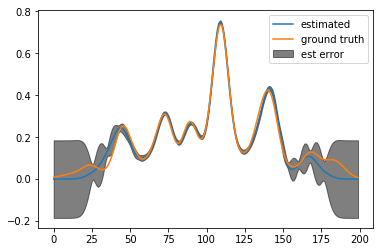

In [19]:
figure()
μ = m.predict_mean0().detach().squeeze().numpy()
σ = m.predict_var0().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(200),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot((data_gen2.mean_A()/data_gen2.n_A).numpy()/2,label='ground truth')
legend()

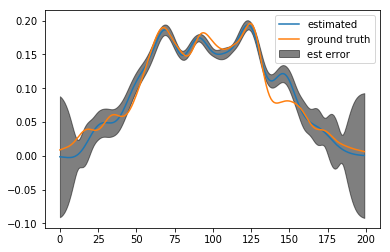

In [20]:
figure()
μ = (m.predict_mean1().detach().reshape(200,200)[:,100]).squeeze().numpy()
σ = (m.predict_var1().detach().reshape(200,200).sqrt()[:,100]).squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(200),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot(((data_gen2.mean_B().reshape(200,200)[:,100])/data_gen2.n_B).numpy()/2,label='ground truth')
legend()

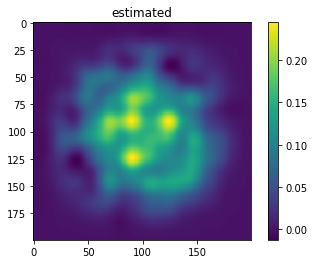

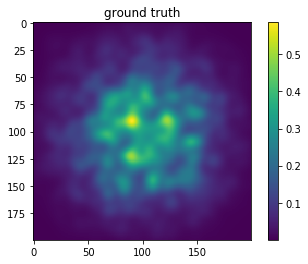

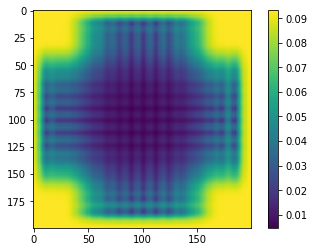

In [22]:
figure()
μ = (m.predict_mean1().detach().reshape(200,200)).numpy()
σ = (m.predict_var1().detach().reshape(200,200).sqrt()).numpy()
imshow(μ)
colorbar()
title('estimated')
figure()
imshow(data_gen2.mean_B().reshape(200,200)/data_gen2.n_B)
title('ground truth')
colorbar()
figure()
imshow(σ)
colorbar()